Authors: Xiaotong Meng, Kevin Janssens and Alissa Ganter

# IKEA Furniture: Comparing different Classfiication Methods

*Note: Please note, that the exact values of the overall accuracy, the accuracy in confusion matrix and even the ranking of the feature importance might differ slightly from the ones written in the Markdowns because of the randomness of the algorithm. This is the case for the Section on the Decision Tree Classifier, Random Forest as well as Boosting.*

## Outline
- [Motivation](#Motivation)
- [Imports](#Imports)
- [Data Analysis](#Data-Analysis)
    - [Import IKEA Furniture Data-Set](#Import-IKEA-Furniture-Data-Set)
    - [Data Visualization](#Data-Visualization)
    - [Targets and Features](#Targets-and-Features)
    - [Correlation](#Correlation)
    - [Data Cleaning](#Data-Cleaning)
    - [Prepare Data for Prediction with a Tree-Based Algorithm](#Prepare-Data-for-Prediction-with-a-Tree-Based-Algorithm)
- [Decision Tree](#Decision-Tree)
    - [Test and Training Data-sets](#Test-and-Training-Data-Sets)
    - [First Version of the Decision Tree](#First-Version-of-the-Decision-Tree)
    - [First Improvements of the Decision Tree](#First-Improvements-of-the-Decision-Tree)
    - [Final Version of the Decision Tree](#Final-Version-of-the-Decision-Tree)
    - [Further Investigations of the Decision Tree](#Further-Investigations-of-the-Decision-Tree)
    - [Pruning](#Pruning)
- [Random Forest](#Random-Forest)
    - [Create a First Version of a Random Forest](#Create-a-First-Version-of-the-Random-Forest)
    - [First Improvements of the Random Forest](#First-Improvements-of-the-Random-Forest)
    - [Final Version of the Random Forest](#Final-Version-of-the-Random-Forest)
    - [Further Investigations of the Random Forest Model](#Further-Investigations-of-the-Random-Forest-Model)
- [Boosting](#Boosting)
    - [Create a First Version of Boosting](#Create-a-First-Version-of-Boosting)
    - [First Improvements of Boosting](#First-Improvements-of-Boosting)
    - [Final Version of Boosting](#Final-Version-of-Boosting)
    - [Further Investigations of Boosting Model](#Further-Investigations-of-Boosting-Model)
- [Conclusion and Remarks](#Conclusion-and-Remarks)


## Motivation

This project investigates the performance of different classification methods is investigated for the IKEA Furniture data-set. The goal is to identify the classification method that can predictthe category of new furniture items best as possible. The performance of the classification methods investigated will be compared based on their prediction accuracy.

Overall, the IKEA data-set contains information on different furniture items sold by IKEA. The data-set will be used to train and test the different classification methods. Common classification methods are the Logistic Regression, K-Nearest-Neighbour, Decision Tree or Support Vector Machines, to name a few. However, while many different classification methods exist, for the scope of this project, the focus will be on tree-based classification methods.

Tree-based classification methods can be used to predict a qualitative response for an observation based on a sequence of splitting rules. The splitting rules are summarized in a tree. An advantage of **Decision Trees** is that they are easy to understand and interpret. In addition, Decision Trees can handle both numerical and categorical data. This will be useful as the IKEA furniture data-set contains both numerical and categorical data. However, decision trees are prone to overfitting and often do not generalise well. Therefore, often trees do not have the same level of prediction accuracy as some other classification methods do.

In order to construct more powerful prediction models, the tree-based classification methods of **Random Forests** and **Boosting** are explored as well. Both Random Forest and Boosting use trees as building blocks in their models.

## Imports

In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns

#import graphviz

from matplotlib import pyplot as plt
from IPython.display import Image, display


%matplotlib inline
plt.style.use('ggplot') 
sns.set(style="white")

## Data Analysis

In a first step the raw data-set is examined more closey. The main goal of the data analysis is to identify useful information and to better understand the data-set at hand. In order to prepare the raw-data for later use, steps of cleansing and transforming are included as well. 

### Import IKEA Furniture Data-Set

In [2]:
IKEA_df = pd.read_csv('Data/IKEA_SA_Furniture_Web_Scrapings_sss.csv')
IKEA_df = IKEA_df.drop(IKEA_df.columns[0],axis =1)
IKEA_df.head(5)

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
0,90420332,FREKVENS,Bar furniture,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0
1,368814,NORDVIKEN,Bar furniture,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN
3,80155205,STIG,Bar furniture,69.0,No old price,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0
4,30180504,NORBERG,Bar furniture,225.0,No old price,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0


In [3]:
m = IKEA_df.shape[0]
n = IKEA_df.shape[1]
print('The data-set contains '+str(m)+' samples and '+str(n-1)+' features including the target-feature \'category\'')

The data-set contains 3694 samples and 12 features including the target-feature 'category'


### Data Visualization 

In the following the feature-names are listed together with their data-type. The target-feature 'category' is also included. Note that the data-set contains both numerical and categorical data. 

In [4]:
# data type  
IKEA_df.dtypes

item_id                int64
name                  object
category              object
price                float64
old_price             object
sellable_online         bool
link                  object
other_colors          object
short_description     object
designer              object
depth                float64
height               float64
width                float64
dtype: object

The data for some features is incomplete:

In [5]:
IKEA_df.count() 

max_count = max(IKEA_df.count())

missing_data = []
for i in range(len(IKEA_df.count())):
        if IKEA_df.count()[i] < max_count:
            missing_data.append(i)
            
features = list(IKEA_df.count()[missing_data].index)
print('The data for the following {} features is incomplete: {}, {}, {}.'.format(len(features),*features))

The data for the following 3 features is incomplete: depth, height, width.


### Targets and Features
In the following an exploratory data analysis of the different features is performed. The main goal is to gain a better understanding of the data-set at hand. For that, each feature and its properties are examined individually.

#### item_id 

In [6]:
nun_id =  IKEA_df['item_id'].nunique()
print(f'Overall, {nun_id} unique item-id\'s exist.')
if nun_id <  m:
    print('However, not every item has a unique item-ID. Either some items share an item-ID or some items might have one and the same item-ID.')

Overall, 2962 unique item-id's exist.
However, not every item has a unique item-ID. Either some items share an item-ID or some items might have one and the same item-ID.


Text(0.5, 0, '')

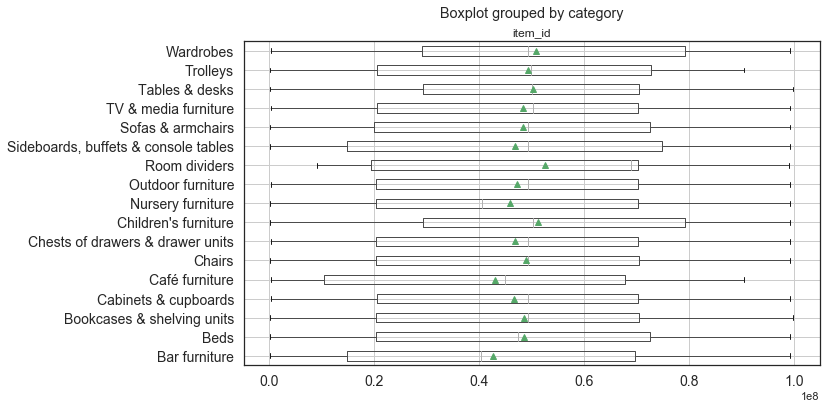

In [7]:
ax0 = IKEA_df.boxplot(column='item_id',by='category',vert=False, figsize=(10,6), fontsize =14,showmeans =True)
ax0.set_xlabel('')

The item_id is a number consisting of 5 to 8 digits. From the boxplot we can derive, that for most categories approximately 50% of the items  are taking a value between 2e7 and 7e7. Thus, item_id probably will not not give strong evidence of the category an item belongs to.  

#### name

In [8]:
nun =  IKEA_df['name'].nunique()
#print(IKEA_df['category'].unique())
print('There are ' + str(nun) + ' unique names in total.' )

There are 607 unique names in total.


In [9]:
name_df =  IKEA_df.groupby('category').agg({'name':'nunique', 'category':'size'})
name_df.columns=['n_uname','size']
name_df['uname [%]'] = name_df['n_uname']/ name_df['size']
name_df.sort_values(['uname [%]'], ascending=False)

,n_uname,size,uname [%]
category,,,
Trolleys,20,28,0.714286
"Sideboards, buffets & console tables",12,23,0.521739
Bar furniture,24,47,0.510638
Café furniture,12,26,0.461538
Chairs,222,481,0.461538
Tables & desks,245,612,0.400327
Room dividers,5,13,0.384615
Beds,76,208,0.365385
TV & media furniture,54,190,0.284211


It seems that the feature 'name' can be helpful when determining the catogory of an item. Especially when predicting items of the category 'Sofas & armchairs' the feature 'name' might play a very important role as close to 87% of the samples of that category do not have an unique name. Similar goes for categories 'Bookcases & shelving units', 'Wardrobes' and 'Nursery furniture'. On the contrary, for category 'trolleys' the feature 'name' might not be as helpful as the number of unique names accounts for more than 70% of the actual category-size. 

#### category

In [10]:
nun =  IKEA_df['category'].nunique()
type_df = IKEA_df.groupby('category').size().reset_index(name='size').sort_values(['size'], ascending=False) 
print(f'There are {nun} categories in total:\n')
print(',\n'.join(list(type_df['category'])))

There are 17 categories in total:

Tables & desks,
Bookcases & shelving units,
Chairs,
Sofas & armchairs,
Cabinets & cupboards,
Wardrobes,
Outdoor furniture,
Beds,
TV & media furniture,
Chests of drawers & drawer units,
Children's furniture,
Nursery furniture,
Bar furniture,
Trolleys,
Café furniture,
Sideboards, buffets & console tables,
Room dividers


Text(0, 0.5, '')

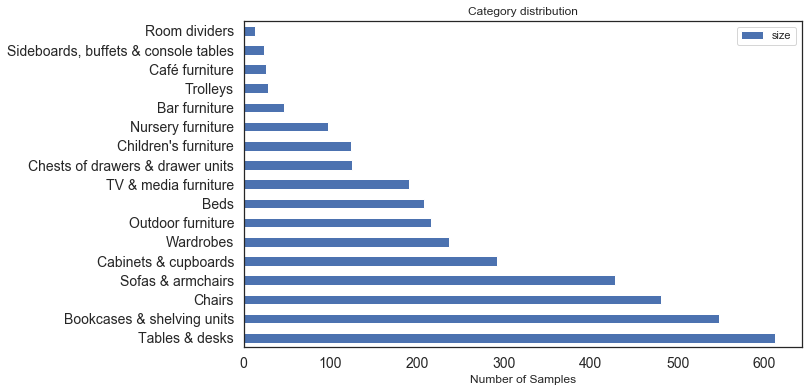

In [11]:
ax1 = type_df.set_index('category').plot.barh(rot=0, title='Category distribution',color = 'b',figsize=(10,6), fontsize=14)
ax1.set_xlabel("Number of Samples")
ax1.set_ylabel('')

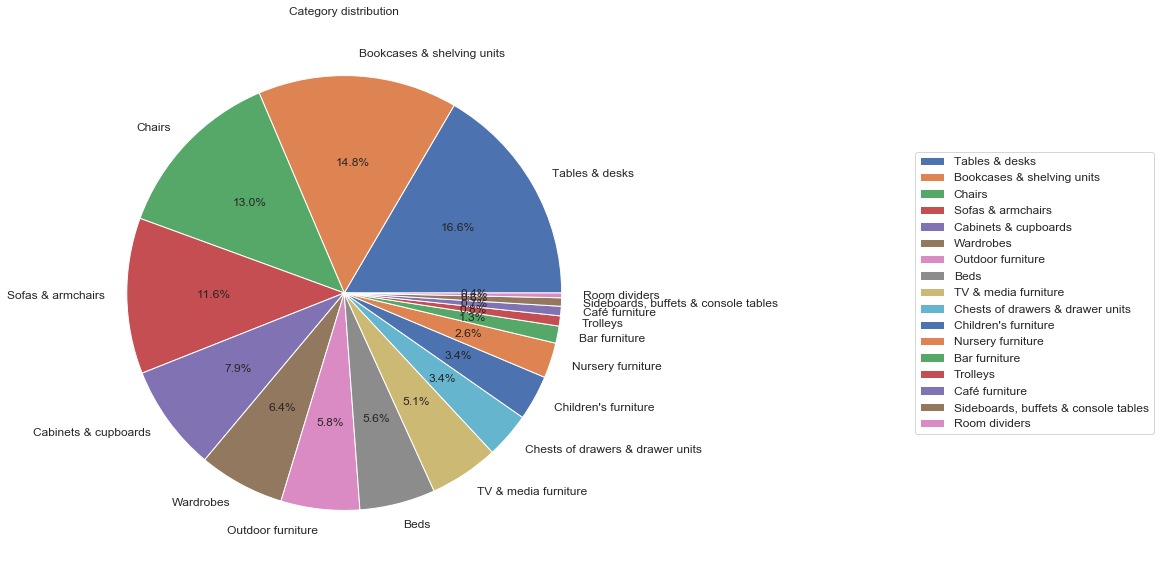

In [12]:
ax = type_df.set_index('category').plot.pie(title='Category distribution', y='size',figsize=(10,10), autopct='%1.1f%%',fontsize=12)
ax.set_ylabel('')
ax.legend(bbox_to_anchor=(2,0.5), loc="right", fontsize=12)

The category distribution is visulized above as a bar graph and as a pie chart. From that, the follwoing observations can be made:\
Overall, almost 17% of the data-samples belong to the category 'Tables & desks' with over 600 samples. The category 'Tables & desks' is followed by the category 'Bookcases & sheiving units' with approx. 15% and the category 'Chairs' with 13%. Together, the top 3 categories account for the majority of the samples.\
On the contrary, the data-samples of the categories 'Room dividers', 'Sideboards', 'buffets & console tables', 'Cafe furniture' and 'Trolleys' account for less than 1%. Thus, it can be concluded that the classification task itself is quite imbalanced. It might be necessary to replicate data-samples of the categories that contain very few samples.

#### price

Text(0.5, 0, 'Euro')

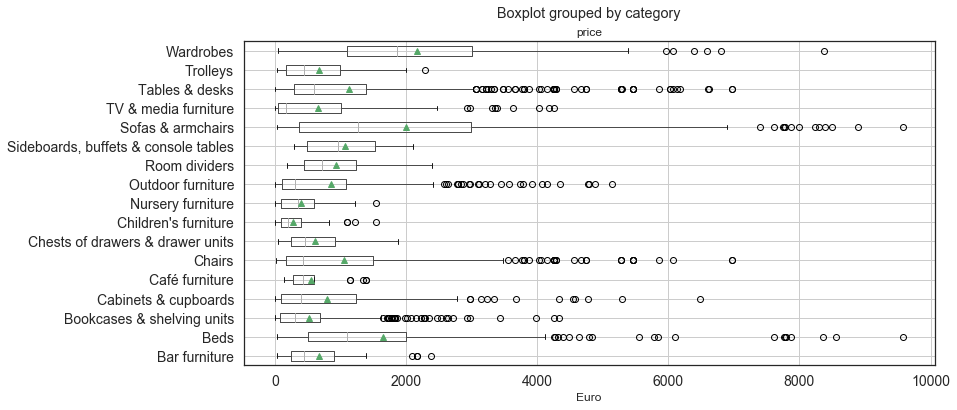

In [13]:
ax2 = IKEA_df.boxplot(column='price',by='category',vert=False, figsize=(12,6), fontsize =14,showmeans =True)
ax2.set_xlabel('Euro')

As shown in the boxplot above, the furniture of category 'Wardrobes' is the most expensive, whereas the children's furnitures is the cheapest. The category 'Sofa & armchairs' has has the largest range in price from approximately 250€ up to 70.000€, while the ourliers can reach up to 90.000€. The category 'Cafe furniture' has the most "stable" price. The price area (Interquartile Range of price) of some categories do overlap. Still, in general it seems fair to say, that price can be a very useful feature in order determine the category of an item.

#### old-price

In [14]:
t = IKEA_df[IKEA_df['old_price'].str.contains('No old price')]['item_id'].count() /m
print(f'{round(t,4)*100}% of the feature \'old_price\' is \'No old price\'.' )

82.3% of the feature 'old_price' is 'No old price'.


It is  impossible to recover this data. Thus, the feature 'old_price' might not be helpful in order to determine the category and therefore will be ignored for training. 

#### sellable_online

In [15]:
t = IKEA_df[IKEA_df['sellable_online'] == True]['item_id'].count()/m
print(f'{round(t,4)*100}% of the feature \'sellable_online\' is \'True\'.' )

99.24% of the feature 'sellable_online' is 'True'.


Thus, the vast majority of items can be sold online. As this feature is identical for most items, it does not give strong evidence of the item-category and will most likely not be helpful when determining the category of a new item. Therefore, the feature can probably be excluded in the training.

#### other_colors

In [16]:
t = IKEA_df[IKEA_df['other_colors'].str.contains('Yes')]['item_id'].count()/m
print(f'{round(t,4)*100}% of feature other_colors is \'Yes\'.' )

40.93% of feature other_colors is 'Yes'.


Again, as the feature 'other_colors' is a 'Yes'-instance for approx. 40% of the samples and a 'No'-instance for the remaining 60% it will probably not give strong evidence of the item-category.

#### designer

In [17]:
nun_designer =  IKEA_df['designer'].nunique()
#print(IKEA_df['designer'].unique())
print('There are ' + str(nun_designer) + ' different designers in total.' )

There are 381 different designers in total.


In [18]:
designer_df = IKEA_df.groupby('designer').size().reset_index(name='count').sort_values(['count'], ascending=False)
designer_df['count%'] = round(designer_df['count'] *100/m ,2) 
designer_df.head(5)

,designer,count,count%
192,IKEA of Sweden,828,22.41
138,Ehlén Johansson,161,4.36
163,Francis Cayouette,151,4.09
344,Ola Wihlborg,134,3.63
279,K Hagberg/M Hagberg,122,3.30


As displayed in the table above, 22% of the items are not designed by a sepecific designer. The designer which designs most items is Ehlén Johanssons. However, Ehlén Johanssons only acount for about 4% of the furniture items in the data-set. The designer 'Ehlén Johanssons' is closely follwoed by the designer 'Francis Cayoutte' who accounts for approx. 4% of the designs as well. 

In [19]:
t = designer_df[designer_df['count']< 2].shape[0]
print(f'{t} of {nun_designer} designers design less than 2 items in data-set.\n')

t = designer_df[designer_df['count']< 5].shape[0]
print(f'{t} of {nun_designer} designers design less than 5 items in data-set.\n')

t  = designer_df[designer_df['count']< 10].shape[0]
print(f'{t} of {nun_designer} designers design less than 10 items in data-set.\n')

139 of 381 designers design less than 2 items in data-set.

278 of 381 designers design less than 5 items in data-set.

320 of 381 designers design less than 10 items in data-set.



In [20]:
IKEA_df['designer_len'] = IKEA_df['designer'].str.len() 
IKEA_df['designer_len'].describe()

count    3694.000000
mean       33.755820
std        86.016629
min         3.000000
25%        14.000000
50%        15.000000
75%        28.000000
max      1261.000000
Name: designer_len, dtype: float64

In [21]:
t = IKEA_df[IKEA_df['designer_len'] > 40].shape[0] 
print(f'{round(t*100/m,2)}% samples actually contain a long item-description in the feature \'designer\' instead of their designer.')

7.26% samples actually contain a long item-description in the feature 'designer' instead of their designer.


We find that some entries in 'desinger' contain a more detailed description of the furniture item itself instead of the designers name. We could replace those entries with 'designer unknown', however,  this might be misleading later on.  Replacing those entries with 'designer unknown' could be understood by the algorithm as if the furniture was designed by one and the same person (called 'designer unknown') when in reality the designer is simply unknown.\
Moreover, the observation can be made that furniture of the same category might have the same description for the feature 'designer'. But considering those mistakes only acount for approx. 7% of the entire data-set, the original data is kept in this case.

#### Let's take a closer look at the TOP3 furniture-designers:
1. IKEA of Schweden (22.41%)
2. Ehlén Johansson (4.36%)
3. Francis Cayouette (4.09%)

*1. IKEA of Schweden (22.41%)*

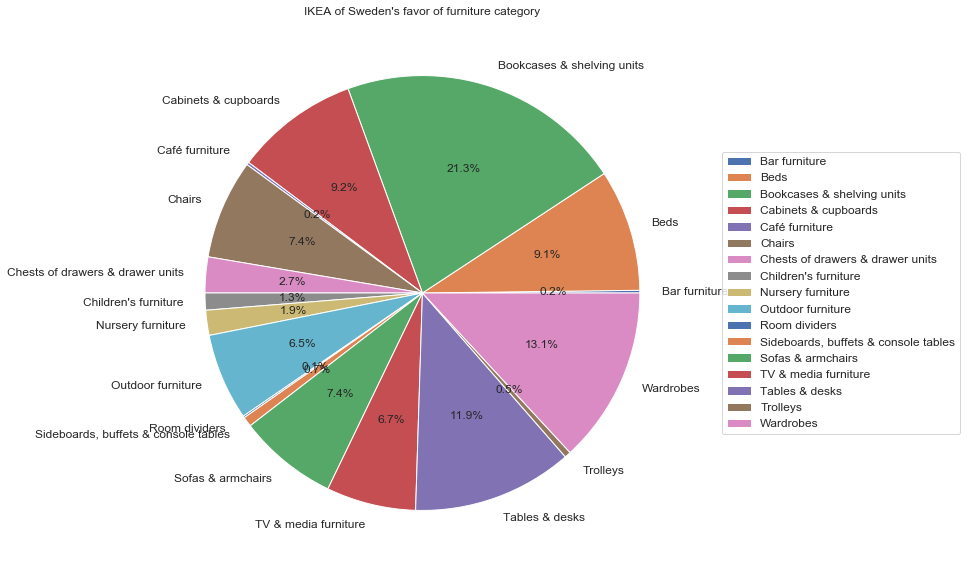

In [22]:
df1 = IKEA_df[IKEA_df['designer'].str.contains('IKEA of Sweden')].groupby('category')['item_id'].count() \
                                    .reset_index(name = 'count')
axd1 = df1.set_index('category').plot.pie(title='IKEA of Sweden\'s favor of furniture category', y='count',figsize=(10,10), \
                                          autopct='%1.1f%%', fontsize=12, legend = None)
axd1.set_ylabel('')
axd1.legend(bbox_to_anchor=(1.5,0.5), loc="right", fontsize=12)

'IKEA of Sweden' covers all 17  furniture catogeries. However, most designs are from the category 'Bookcases & shelving units' accounting for a little over 20% of all designs.

*2. Ehlén Johansson (4.36%)*

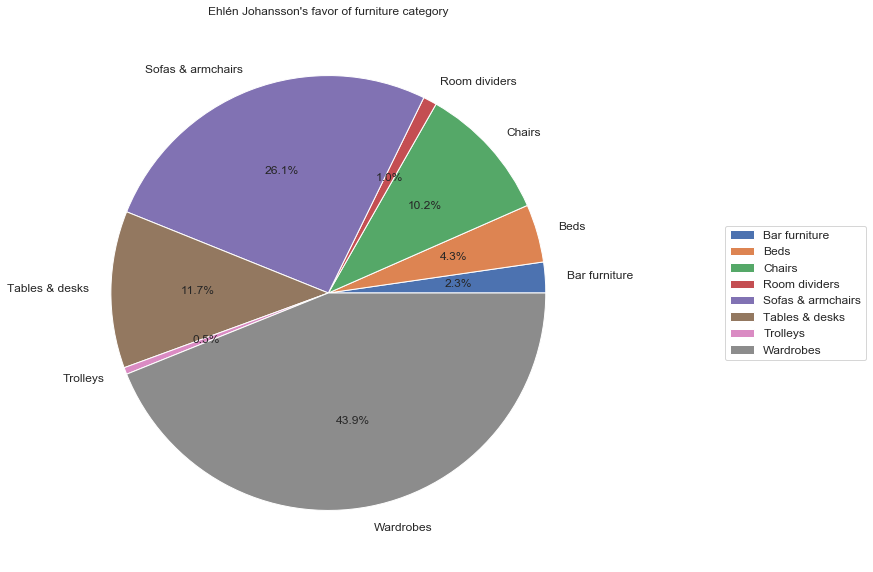

In [23]:
df2 = IKEA_df[IKEA_df['designer'].str.contains('Ehlén Johansson')].groupby('category')['item_id'].count() \
                                    .reset_index(name = 'count')
axd2 = df2.set_index('category').plot.pie(title='Ehlén Johansson\'s favor of furniture category', y='count',figsize=(10,10), \
                                          autopct='%1.1f%%', fontsize=12, legend = None)
axd2.set_ylabel('')
axd2.legend(bbox_to_anchor=(1.5,0.5), loc="right", fontsize=12)

Designer 'Ehlén Johansson' seems to favor designing for the category 'Wardrobes' (over 40%), followed by category 'Sofas & armchairs' with a little over 26%.
Rather as a coincidence it was noticed, that the designer 'Ehlén Johansson' is sometimes listed as 'IKEA of Sweden/Ehlén Johansson' and other times as 'Ehlén Johansson/IKEA of Sweden'. This will be addressed later on in the section on data cleaning.

In [24]:
t1 = IKEA_df[IKEA_df['category'].str.contains('Wardrobes')]['item_id'].count() 
t2 = IKEA_df[IKEA_df['category'].str.contains('Wardrobes') & IKEA_df['designer'].str.contains('Ehlén Johansson')]['item_id'].count() 
print('About ' +str(round(t2/t1, 4)*100)+ '% of the items of category \'Wardrobes\' are designed by Ehlén Johansson (including the cases \'IKEA of Sweden/Ehlén Johansson\' and \'Ehlén Johansson/IKEA of Sweden\').')

About 73.31% of the items of category 'Wardrobes' are designed by Ehlén Johansson (including the cases 'IKEA of Sweden/Ehlén Johansson' and 'Ehlén Johansson/IKEA of Sweden').


*3. Francis Cayouette (4.09%)*

Text(0, 0.5, '')

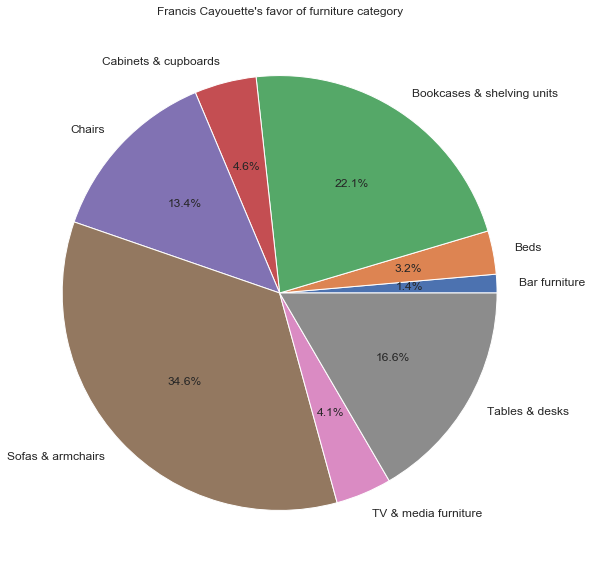

In [25]:
df3 = IKEA_df[IKEA_df['designer'].str.contains('Francis Cayouette')].groupby('category')['item_id'].count() \
                                    .reset_index(name = 'count')
axd3 = df3.set_index('category').plot.pie(title='Francis Cayouette\'s favor of furniture category', y='count',figsize=(10,10),\
                                          autopct='%1.1f%%', fontsize=12, legend = None)
axd3.set_ylabel('')

Designer Francis Cayouette favors designing 'Sofas & armchairs' (approximately 35%), followed by the category 'Bookcases & sehlving units' with a little over 22% and the category 'Tables % desks' accounting for almost 17%. 

In [26]:
t1 = IKEA_df[IKEA_df['category'].str.contains('Sofas & armchairs')]['item_id'].count() 
t2 = IKEA_df[IKEA_df['category'].str.contains('Sofas & armchairs') & IKEA_df['designer'].str.contains('Francis Cayouette')]['item_id'].count() 
print(f'Overall, around {round(t2/t1, 4)*100}% of the items in category \'Sofas & armchairs\' are designed by Francis Cayouette.')

Overall, around 17.52% of the items in category 'Sofas & armchairs' are designed by Francis Cayouette.


#### depth, width,  height

In the following the features regarding the item-size are examined more closely.

Text(0.5, 0, 'cm')

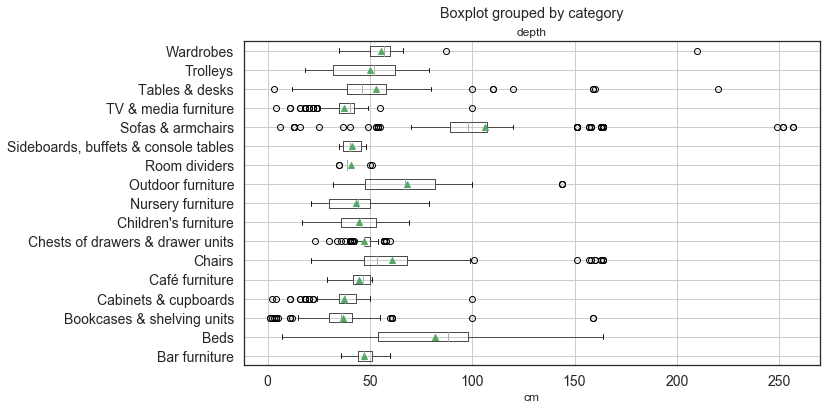

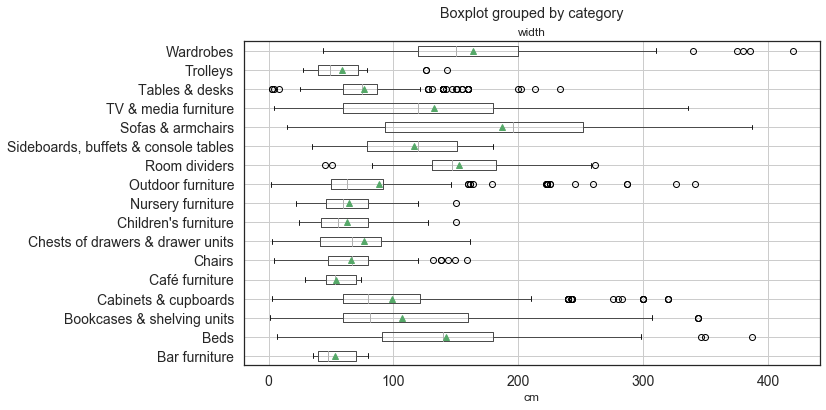

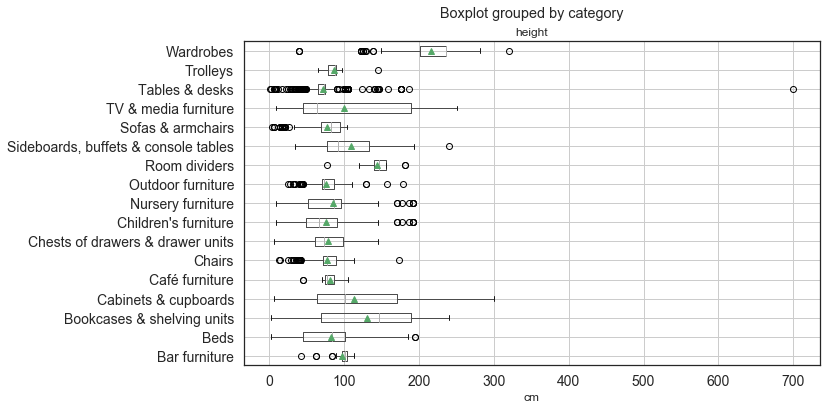

In [27]:
# depth boxplot
ax3 = IKEA_df.boxplot(column='depth',by='category',vert=False, figsize=(10,6), fontsize =14,showmeans =True)
ax3.set_xlabel('cm')
# width boxplot
ax5 = IKEA_df.boxplot(column='width',by='category',vert=False, figsize=(10,6), fontsize =14,showmeans =True)
ax5.set_xlabel('cm')
# height boxplot
ax4 = IKEA_df.boxplot(column='height',by='category',vert=False, figsize=(10,6), fontsize =14,showmeans =True)
ax4.set_xlabel('cm')

In general, the size-features 'depth', 'width' and 'height' vary a lot throughout the different categories. This is true in particular for the feature 'depth'. Therefore, it is presumed that the size-features play an important role in predicting the category of an items. 

#### link, short_description

In [28]:
nun_link =  IKEA_df['link'].nunique()
size_link = IKEA_df['link'].size
print(f'The feature \'link\' contains {nun_link} unique values which accounts to {round(nun_link/size_link*100,2)}%.')

The feature 'link' contains 2962 unique values which accounts to 80.18%.


In [29]:
nun_sd =  IKEA_df['short_description'].nunique()
size_sd = IKEA_df['short_description'].size
print(f'The feature \'link\' contains {nun_sd} unique values which accounts to {round(nun_sd/size_sd*100,2)}%.')

The feature 'link' contains 1706 unique values which accounts to 46.18%.


The features 'link' and 'short_desctiption' can be understood literally. Both features 'link' and 'short_description' are unique for the majority of the items. Therefore, 'link' and 'short_description' will be ignored for the training.

However, it should not go unnoted that 'short_description' sometimes contains size-data,  which was not scrapped and assgined correctly. We can make use of this and recover some of the missing data (NaN-cells) for 'depth', 'width' and 'height'. Unfortunately, in most cases this is very complicated to achieve. Furthermore, both features 'link' and 'short_description' contain key words, which would indicate the items category right away. Thus, it might be viewed as cheating to make use of that, while at the same time it would be extremely difficult to do so.

### Correlation

We would like to check the colinerity of numerical (including boolean) features. We can encode the nominal features as integer values by using 'factorize'.\ 
Although, this can be misleadings in some way, at this point we just want to have an idea of the correlation between the features. In case of training an algorithm that does not understand nominal features, we might use the one-hot encoding to avoid misunderstandings caused by numeric values. However, this can lead to a quite high computational cost. For example, for 370 different designers, one-hot encoding will create 9 more features, respectively, taking value 0/1 to present the feature designer.

Text(0.5, 1, 'Correlation between features')

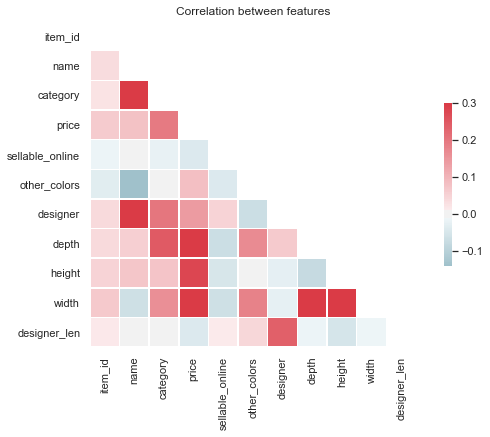

In [30]:
corr_df = IKEA_df.copy()

corr_df['category'] = pd.factorize(corr_df['category'])[0] + 1
corr_df['name'] = pd.factorize(corr_df['name'])[0] + 1
corr_df['sellable_online'] = pd.factorize(corr_df['sellable_online'])[0] + 1
corr_df['other_colors'] = pd.factorize(corr_df['other_colors'])[0] + 1
corr_df['designer'] = pd.factorize(corr_df['designer'])[0] + 1

# correlation / scatter matrix here
corr = corr_df.corr()

# create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(10, 6))
# colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# create heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation between features')

As suspected previously, the features 'depth' and 'price' play a relatively important role in determining the category of an item, whereas the features 'sellable_online' and 'other_colors' show a lower correlation to 'category'. 
Besides the item-category, the feature 'price' also shows a relatively high correlation to 'depth', 'height' and 'width'. FThe features 'name' and 'designer' show a relatively high correlation as well, indicating a colinearity of the features. This might result in bad predicitons for certain algorithms. However, in each case the correlation is less than 0.3, thus, the correlation between the features (including the target category) is not on a very high level.

### Data Cleaning

The goal of the data cleaning is to detect and then correct corrupt or inaccurate data as well as prepare the data for later use.\
First of, the feature 'other_colors' is transformed from an object with a 'Yes'- and 'No'-instance to a boolean:

In [31]:
IKEA_df['other_colors'] = IKEA_df['other_colors'].map({'Yes': True, 'No': False})

Rather coincidentally we noticed that the designer 'Ehlén Johansson' is sometimes listed as 'IKEA of Sweden/Ehlén Johansson' and other times as 'Ehlén Johansson/IKEA of Sweden'. Because this is one and the same person, the two are merged and saved as 'Ehlén Johansson/IKEA of Sweden'.

In [32]:
s1 = IKEA_df[IKEA_df['designer'].str.contains('IKEA of Sweden/Ehlén Johansson')].shape[0]
s2 = IKEA_df[IKEA_df['designer'].str.contains('Ehlén Johansson/IKEA of Sweden')].shape[0]
l = IKEA_df['designer'].shape[0]
s3 = round((s1+s2)/l,4)*100
s4 = s4 = int(designer_df[designer_df['designer']=='Ehlén Johansson']['count%'])

print(f'Ehlén Johansson accounts for {s1} designs as \'IKEA of Sweden/Ehlén Johansson\' and for {s2} designs as \'Ehlén Johansson/IKEA of Sweden\'.')
print(f'Thus, in total {s1+s2} of the designs are from the desginer Ehlén Johansson. This means, in reality Ehlén Johansson accounts for {s3}% of the designs. This is an increase of {round(s3-s4,2)}%.')

IKEA_df['designer']= np.where(IKEA_df['designer'].str.contains('IKEA of Sweden/Ehlén Johansson'),  'Ehlén Johansson/IKEA of Sweden', IKEA_df.designer)

Ehlén Johansson accounts for 79 designs as 'IKEA of Sweden/Ehlén Johansson' and for 86 designs as 'Ehlén Johansson/IKEA of Sweden'.
Thus, in total 165 of the designs are from the desginer Ehlén Johansson. This means, in reality Ehlén Johansson accounts for 4.47% of the designs. This is an increase of 0.47%.


Next, the cells containing 'NaN' values are investigated more closely in order to determine which features are missing data.

In [33]:
shape_NaN = IKEA_df[IKEA_df.isnull().any(axis=1)].shape 
IKEA_df[IKEA_df.isnull().any(axis=1)].head(4)

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width,designer_len
0,90420332,FREKVENS,Bar furniture,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,False,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0,20
1,368814,NORDVIKEN,Bar furniture,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,False,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0,17
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,False,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN,17
7,60155602,DALFRED,Bar furniture,195.0,No old price,True,https://www.ikea.com/sa/en/p/dalfred-bar-stool...,False,"Bar stool, 63-74 cm",Sarah Fager,50.0,NaN,50.0,11


It seems like data is only missing regarding the size-features 'depth', 'height', 'width'. Let's check if this is true:

In [34]:
size = ['depth','height','width'] 
shape_size = IKEA_df[IKEA_df[size].isnull().any(axis=1)].shape 
s = IKEA_df[IKEA_df[IKEA_df.columns[~IKEA_df.columns.isin(size)]].isnull().any(axis=1)].shape
if s[0] == 0:
    print('This assumption was correct. All \'NaN\'-entries can be found in the rows \'depth\', \'height\', \'width\'.')

This assumption was correct. All 'NaN'-entries can be found in the rows 'depth', 'height', 'width'.


In [35]:
IKEA_df[IKEA_df[size].isnull().all(axis=1)].head(4)

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width,designer_len
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,False,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN,17
9,69304221,EKEDALEN / EKEDALEN,Bar furniture,2176.0,"SR 2,375",True,https://www.ikea.com/sa/en/p/ekedalen-ekedalen...,False,Bar table and 4 bar stools,Ehlén Johansson,NaN,NaN,NaN,15
28,29297227,STENSELE / NORRARYD,Bar furniture,1340.0,No old price,True,https://www.ikea.com/sa/en/p/stensele-norraryd...,False,Bar table and 2 bar stools,Nike Karlsson/Maja Ganszyniec,NaN,NaN,NaN,29
32,19297275,NORRÅKER / NORRÅKER,Bar furniture,1266.0,"SR 1,385",True,https://www.ikea.com/sa/en/p/norraker-norraker...,False,"Bar table and 2 bar stools, 7...",J Karlsson/N Karlsson,NaN,NaN,NaN,21


#### NaN in size data

By comparing the data in the IKEA furniture data-set to the product sizes published on the website, the conclusion can be made, that there are several reasons as to why some of the data regarding the item-size is missing.

First of, it seems that some data is not successfully scraped from the website. When the item-size is not recorded in the short description either, it is impossible to recover the missing information.
Second, some items represent a set of different furniture items. In those cases there is no product size in that sense.
Third, some items are variable in size so e.g. instead of a a fix width, a range is given.

Although in some cases part of the missing data could be retrieved from the the short description, it is very difficult to do so for all items. The biggest problem is that it cannot be identified what numbers respond to which feature ('depth', 'height' or 'width'). Furthermore, often the size-data in the short description is incomplete as well.

Last, there are some small items where the measurements are taken in milimeters instead of centimeter. In addition, for some items a item-diameter is recorded in the short descritpion instead of the item-height.

In a first step, the size-data is separated from the short description. Then the size is split into the numeric value ('size_nounit') and its unit.

In [36]:
IKEA_df['size']= IKEA_df['short_description'].str.rsplit(',', n=1).str[1]
IKEA_df['short_description']= IKEA_df['short_description'].str.rsplit(',', n=1).str[0]

IKEA_df['unit'] = IKEA_df['size'].str.replace('\d+|-|x', ' ')
IKEA_df['size_nounit'] = IKEA_df['size'].str.replace('cm|mm', '')

The following will show, that indeed, 'height' is not given for small items. In this case it is convenient to extract the diameter from the short description and replace the NaN-value in height with the diamater. Additionally, the information given on the website indicates that the unit of the size-data for small items is in fact 'mm'. Therefore, the unit for small items will be corrected in the following.  

In [37]:
IKEA_df[IKEA_df['unit'].str.contains('mm') & IKEA_df[size].isnull().any(axis=1)].shape

(132, 17)

In [38]:
IKEA_df[IKEA_df['unit'].str.contains('mm') & IKEA_df['height'].isnull()].shape

(132, 17)

In [39]:
IKEA_df['height'] = np.where(IKEA_df['unit'].str.contains('mm') , IKEA_df.size_nounit, IKEA_df.height)
IKEA_df['height'] = np.where(IKEA_df['unit'].str.contains('mm'), IKEA_df.height.astype(float)/10, IKEA_df.height)
IKEA_df['height'] = IKEA_df['height'].astype(float)

In [40]:
IKEA_df['depth'] = np.where(IKEA_df['unit'].str.contains('mm'), IKEA_df.depth.astype(float)/10, IKEA_df.depth)

In [41]:
IKEA_df['width'] = np.where(IKEA_df['unit'].str.contains('mm'), IKEA_df.width.astype(float)/10, IKEA_df.width)

For simplicity, the 'NaN'-cells in size-data are filled with either the mean or the median depending on the category and wether there are many outliers in the size-data (refer to the boxplot from earlier).\
In most cases the mean will be used. However, if there are many outliers resulting in the mean beeing significantly higher than the median, the NaN-cells are filled with the median instead.

In [42]:
dm =IKEA_df.groupby('category')['depth'].median().reset_index(name = 'depth_median')
dd = IKEA_df.groupby('category')['depth'].mean().reset_index(name = 'depth_mean')
hm = IKEA_df.groupby('category')['height'].mean().reset_index(name = 'height_mean')
hd = IKEA_df.groupby('category')['height'].median().reset_index(name = 'height_median')
wm= IKEA_df.groupby('category')['width'].median().reset_index(name = 'width_median')
wd =IKEA_df.groupby('category')['width'].mean().reset_index(name = 'width_mean')

In [43]:
IKEA_df = IKEA_df.join(dm.set_index('category'), on='category')
IKEA_df = IKEA_df.join(dd.set_index('category'), on='category')
IKEA_df = IKEA_df.join(hm.set_index('category'), on='category')
IKEA_df = IKEA_df.join(hd.set_index('category'), on='category')
IKEA_df = IKEA_df.join(wm.set_index('category'), on='category')
IKEA_df = IKEA_df.join(wd.set_index('category'), on='category')

In [44]:
IKEA_df['depth'] = np.where( (IKEA_df['depth'].isnull()) & (IKEA_df['category'].str.contains('Tables & desks')),  \
                              IKEA_df.depth_median, IKEA_df.depth )
IKEA_df['depth'] = np.where( (IKEA_df['depth'].isnull()) & (IKEA_df['category'].str.contains('Sofas & armchairs')),  \
                              IKEA_df.depth_median, IKEA_df.depth )        
IKEA_df['depth'] = np.where( (IKEA_df['depth'].isnull()) & (IKEA_df['category'].str.contains('Chairs')),  \
                              IKEA_df.depth_median, IKEA_df.depth )

In [45]:
IKEA_df['height'] = np.where( (IKEA_df['height'].isnull()) & (IKEA_df['category'].str.contains('TV & median furniture')),  \
                              IKEA_df.height_median, IKEA_df.height )
IKEA_df['height'] = np.where( (IKEA_df['height'].isnull()) & (IKEA_df['category'].str.contains('Sideboards, buffets,console tables')),  \
                              IKEA_df.height_median, IKEA_df.height )

In [46]:
IKEA_df['width'] = np.where((IKEA_df['width'].isnull()) & (IKEA_df['category'].str.contains('Wardrobes')),  \
                            IKEA_df.width_median, IKEA_df.width)
IKEA_df['width'] = np.where((IKEA_df['width'].isnull()) & (IKEA_df['category'].str.contains('Outdoor furniture')),  \
                            IKEA_df.width_median, IKEA_df.width)
IKEA_df['width'] = np.where((IKEA_df['width'].isnull()) & (IKEA_df['category'].str.contains('Carbinets & cupboards')),  \
                            IKEA_df.width_median, IKEA_df.width)
IKEA_df['width'] = np.where((IKEA_df['width'].isnull()) & (IKEA_df['category'].str.contains('Bookcases & shelving units')),  \
                            IKEA_df.width_median, IKEA_df.width)

In [47]:
IKEA_df['depth'] = np.where(IKEA_df['depth'].isnull(), IKEA_df.depth_mean, IKEA_df.depth)
IKEA_df['height'] = np.where(IKEA_df['height'].isnull(), IKEA_df.height_mean, IKEA_df.height)
IKEA_df['width'] = np.where(IKEA_df['width'].isnull(), IKEA_df.width_mean, IKEA_df.width)

### Prepare Data for Prediction with Tree-Based Algorithms

Tree-based algorithms do not work with calculating distances. Therefore, it is sufficient to factorize the categorical features.

In [48]:
learn = ['item_id','name','category','price','sellable_online','other_colors','designer','depth','height','width' ]
learn_df = IKEA_df [learn]

*Note: This cell gives warning about setting copy. This warning can be ignored for this project.*

In [49]:
learn_df['category_num'] = pd.factorize(learn_df['category'])[0] + 1
learn_df['name'] = pd.factorize(learn_df['name'])[0] + 1
learn_df['designer'] = pd.factorize(learn_df['designer'])[0] + 1

/Users/alissaganter/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/alissaganter/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/alissaganter/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [50]:
if learn_df[learn_df.isna().any(axis =1)]['item_id'].count() ==0:
    print('Now, the dataframe does not contain any \'NaN\'-entries.')

Now, the dataframe does not contain any 'NaN'-entries.


In [51]:
label = IKEA_df['category'].unique()
label = label.tolist()
print('labels:')
print(*label, sep=", ")

labels:
Bar furniture, Beds, Bookcases & shelving units, Cabinets & cupboards, Café furniture, Chairs, Chests of drawers & drawer units, Children's furniture, Nursery furniture, Outdoor furniture, Room dividers, Sideboards, buffets & console tables, Sofas & armchairs, Tables & desks, Trolleys, TV & media furniture, Wardrobes


In [52]:
t = learn_df.drop(columns = ['category','category_num']).shape[1]
print('There are '+str(t)+' features in total.')

There are 9 features in total.


After modifying and cleaning the dataframe, it is now suitable for tree-based algorithms.

## Decision Tree

In [53]:
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import graphviz
import time

As described earlier, we start off with exploring the method of Classification Trees. One advantage of Trees is, that they can easily handle qualitative variables without the use of dummy variables. Furthermore, Decision Trees are easy to visualize and interpret. Therefore, this method seems to be particularly fitting for the classification problem at hand.

### Test and Training Data-Sets

Before creating a first version of the Decision Tree, the data-set is split into a training  and a test data-set. In the following the function 'train_test_split' from scikit-learn will be used to split the data-set, whereas 2/3 of the data will be used for training and 1/3 for testing.\
In order to generate reproducible outputs across multiple function calls, the parameter ``random_state`` is set to an integer value. At default the```random_stat``` would be set to 'None'.

In [54]:
train_size = 0.67
random_state = 1 

In [55]:
def test_train_dataset(df, predictors, size, state):
    
    X = df[predictors].values
    y = df.category.values.reshape(-1,1) # get the response
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size,  random_state=state) 
    
    return X_train, X_test, y_train, y_test

### First Version of the Decision Tree

For a first version of the decision tree, the minimum number of samples required to be at a leaf node (``min_samples_leaf``) is set to 20. We will examine the influence of this parameter on the model accuracy more closely later on.

In [56]:
clf = tree.DecisionTreeClassifier(min_samples_split=20)

The predictors for this first model will be the follwing features: 'item_id', 'name', 'price', 'sellable_online', 'other_colors', 'designer', 'depth', 'height', 'width'. 
In the nex steps, the data-set (learn_df) is split into a training and test data-set. Then, the model can be trained and first predictions can be made.

In [57]:
predictors = learn_df.columns.tolist()
predictors.remove('category')
predictors.remove('category_num')

In [58]:
X_train, X_test, y_train, y_test = test_train_dataset(learn_df, predictors, train_size, random_state)

In [59]:
tree_est = clf.fit(X_train, y_train) 
y_pred = tree_est.predict(X_test)

#### Visualization

The tree is visualized using graphviz from scikit-learn's. As the tree is quite large and gets really hard to read with increasing depth, only part of the tree is visualized here. 

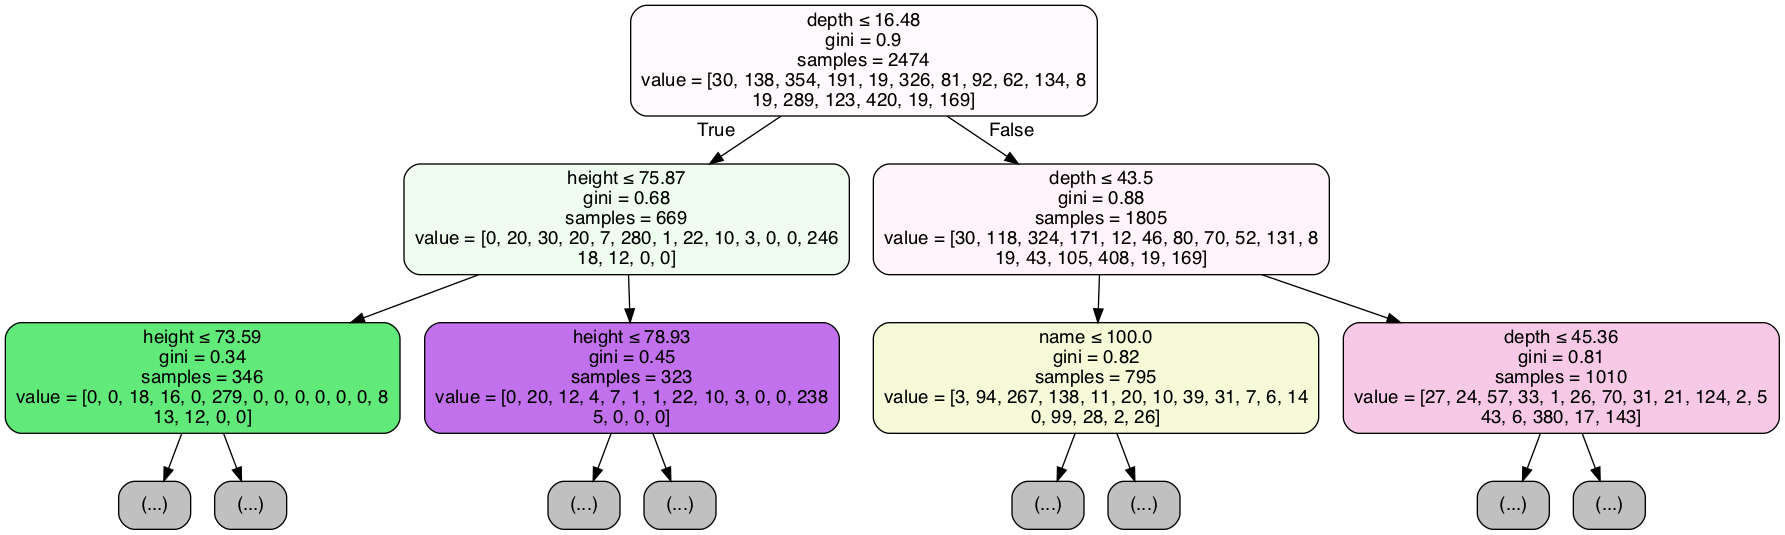

In [60]:
dot_data = tree.export_graphviz(tree_est, out_file='decision_tree_1.dot',feature_names=predictors, 
                filled=True, rounded=True, special_characters=True, precision = 2, max_depth = 2)

with open('decision_tree_1.dot') as f:
    dot_graph = f.read()


I = graphviz.Source(dot_graph, format='png', engine='dot')

Image(I.render())
#I.view()

From the visualization we learn that the initial splitting occurs with the predictors 'depth' and 'height' predictors.

#### Evaluation of the First Version

In a first step the importance of the individual features used as predictors is investigated. For that, the Gini Indices of the different features are compared. 

In [61]:
feature_importances = tree_est.feature_importances_
pd.DataFrame(data=feature_importances, index=predictors, columns = ['Importance']).sort_values(by=['Importance'], 
                                                                                                ascending=False)

,Importance
depth,0.416935
height,0.298461
name,0.195664
price,0.034017
width,0.022311
designer,0.020436
item_id,0.007963
other_colors,0.004212
sellable_online,0.000000


As the table shows, the most important features according to the Gini Index are 'depth' (approx. 40%), 'height' (approx. 30%) and 'name' (approx. 20%). The other features such as 'price', 'width' or 'designer' each account for less than 5%. As suspected earlier, when analyzing the data-set, the feature 'sellable_online' does not have great importance as almost all products are sellable-online. Similar goes for the feature 'other_colors', as most items are available in different colors. On the contrary, 'item_id' is unique for the vast majority of items, therefore the feature 'item_id' is not a good indicator for the item category as well, resulting in a low importance of the feature as a predictor.

In a next step the confusion matrix is created and the training and test accuracy is computed.

Text(66.45312499999999, 0.5, 'Actual')

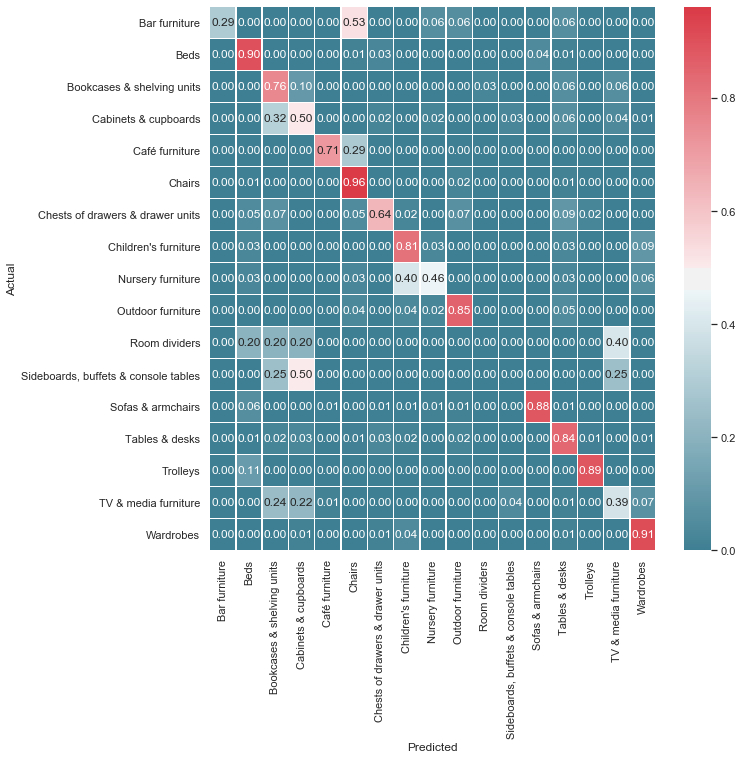

In [62]:
cm = confusion_matrix(y_true = y_test, y_pred=y_pred, labels=label) 

# number of samples that actually belong to each category
cm_sum = cm.sum(axis = 1)
cm1 = np.zeros((len(label),len(label)))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(len(label)):
    cm1[k,:] = cm[k,:]/cm_sum[k]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = label, columns=label)

# plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

The confusion matrix shows that the prediction works well for most categories. However, the decision tree performs poorly for items of categories 'Room dividers' and 'Sideboards, buffets & console tables'. The prediction power is also quite low for the categories 'Bar furniture', 'Nursery furniturs' and 'TV & media furniture'. 

In [63]:
y_pred_train = tree_est.predict(X_train)

accuracy_train_1 = accuracy_score(y_train, y_pred_train)
print("Training accuracy:", round(accuracy_train_1,4))

accuracy_test_1 = accuracy_score(y_test, y_pred)
print("Test accuracy:", round(accuracy_test_1,4))

Training accuracy: 0.8601
Test accuracy: 0.7705


### First Improvements of the Decision Tree

In a first attempt to improve the decision tree, all features with an importance of less than 2% are excluded from the set of predictors. This is the case for the following features: 'item_id', 'other_colors' and 'sellable_online'. The dataframe is adjusted and a new training and test data-set are created. Then, then the decision tree is trained and tested again.

In [64]:
learn = ['item_id','name','price','designer','depth','height','width','category','category_num' ]
learn_df_improvement = learn_df[learn]

In [65]:
predictors.remove('item_id')
predictors.remove('other_colors')
predictors.remove('sellable_online')

In [66]:
print(f'Now we have {len(predictors)} predictors:')
print(*predictors, sep=", ")

Now we have 6 predictors:
name, price, designer, depth, height, width


In [67]:
X_train, X_test, y_train, y_test = test_train_dataset(learn_df_improvement, predictors, train_size, random_state)

In [68]:
clf = tree.DecisionTreeClassifier(min_samples_split=20)
tree_est = clf.fit(X_train, y_train)
y_pred = tree_est.predict(X_test)

#### Evaluation of the First Improvement

Again, in a first step the Gini Index of the individual features which were used as predictors are compared. Then the confusion matrix is created and the training and test accuracy is computed. 

In [69]:
feature_importances = tree_est.feature_importances_
pd.DataFrame(data=feature_importances, index=predictors, columns = ['Importance']).sort_values(by=['Importance'], 
                                                                                                ascending=False)

,Importance
depth,0.418969
height,0.289473
name,0.206004
price,0.036986
designer,0.026317
width,0.022251


The results are very similar to the the first decision tree. Again, 'depth' is the most important feature, this time with a little over 40%. The feature 'depth' is followed by 'height' and 'name' which account to almost 30% and slightly over 20%, respectively. The features with the lowest importance are 'price', 'designer' and 'width'. As for the first decision tree, again the Gini Index of each is below 5%. 

Text(66.45312499999999, 0.5, 'Actual')

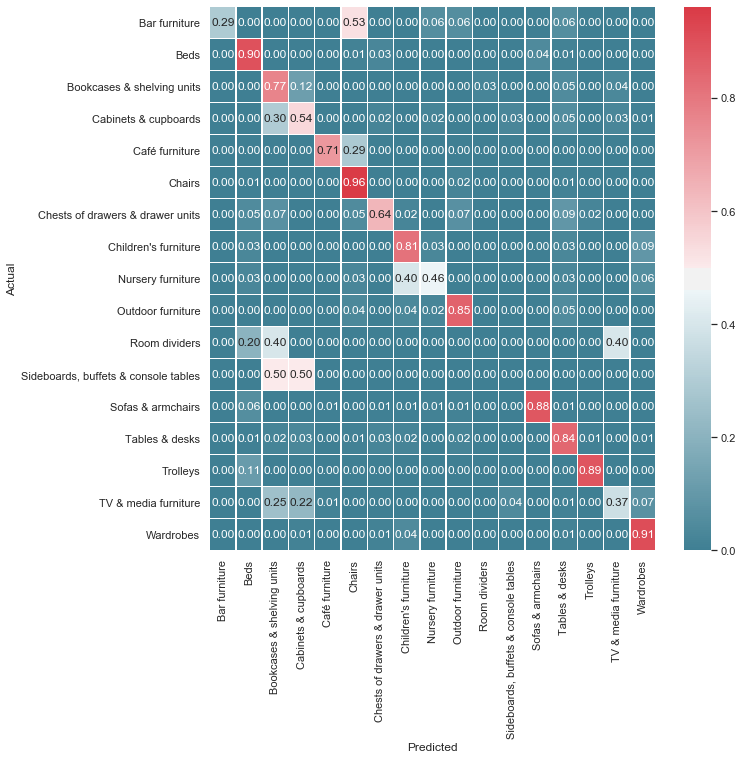

In [70]:
cm = confusion_matrix(y_true = y_test, y_pred=y_pred, labels=label) 

# number of samples actually belong to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((len(label),len(label)))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(len(label)):
    cm1[k,:] = cm[k,:]/cm_sum[k]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = label, columns=label)

#plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

The confusion matrix is very similar to the one of the first decision tree. Although, the prediction was improved ever so slightly for some categories (e.g. 'Cabinets and Cupboards' with + 0.04), the decision tree still performs poorly when predicting the category of items that belong to the categories 'Room dividers' and 'Sideboards, buffets & console tables'. Also, the prediction accuracy of the following categories is not very satisfying as well: 'Bar furniture', 'Nursery furniture' and 'TV & media furniture'.\
Recall, that the data-set is quite imbalanced. It is noticed that both 'Room dividers' and 'Sideboards, buffets & console tables' have very few samples which could explain the lowe prediction accuracy. To address the imbalanced data-set and create a more balanced multi-classification task, some data-samples could be replicated.\
Further notice that often times the categories 'Nursery furniture' and 'Childrens furniture' are mixed up. One reason for this mix-up could be, that the furniture has very similar measurements in both cases. As 'depth', 'width', and 'height' are one of the more important features when predicting the item-category, this could explain the error.

In [71]:
# training accuracy 
y_pred_train = tree_est.predict(X_train)
accuracy_train_2 = accuracy_score(y_train, y_pred_train)
improvement_train = round(((accuracy_train_2-accuracy_train_1)/accuracy_train_2)*100,2)
print(f"Training accuracy: {round(accuracy_train_2,4)}.")
if improvement_train >0.0:
    print(f"The training accuracy improved by {improvement_train}%.\n")
elif improvement_train <0.0:
    print(f"The training accuracy deteriorated by {improvement_train}%.\n")
elif improvement_train == 0.0:
    print("No improvement of the training accuracy.\n")

# test accuracy
accuracy_test_2 = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {round(accuracy_test_2,4)}.")
improvement_test = round(((accuracy_test_2-accuracy_test_1)/accuracy_test_2)*100,2)
if improvement_test >0.0:
    print(f"The test accuracy improved by {improvement_test}%.\n")
elif improvement_test <0.0:
    print(f"The test accuracy deteriorated by {improvement_test}%.\n")
elif improvement_test == 0.0:
    print("No improvement of the test accuracy.\n")

Training accuracy: 0.8561.
The training accuracy deteriorated by -0.47%.

Test accuracy: 0.7746.
The test accuracy improved by 0.53%.



#### Replicate the Samples for a Small Sample Size

In the data analysis we found, that the sample size varies depending on the category. We noticed that especially for those categories, that have fewer samples, the decision tree performs poorly. In an effort to balance the sample size for those categories with very few samples, samples were replicated. 
Recall the sample size of the individual categories:

In [72]:
size_df = learn_df_improvement.groupby('category').size().reset_index(name='size')
size_df

,category,size
0,Bar furniture,47
1,Beds,208
2,Bookcases & shelving units,548
3,Cabinets & cupboards,292
4,Café furniture,26
5,Chairs,481
6,Chests of drawers & drawer units,125
7,Children's furniture,124
8,Nursery furniture,97
9,Outdoor furniture,216


Remember the confusion matrix after the first improvments: The prediction accuracy of the categories 'Sideboards, buffets & console tables', 'Room dividers' was significantly lower than for the other categories. Both categories have a very low number of samples compared to other categories such as 'Beds' where the prediction accuracy was 90%.

*Note: Careful, here the order of the labels changed compared to the list 'label' above. Thus, we cannot use the list 'label' to display the correct order of column names in this section. Therefore, a new list with the correct order of labels was created: 'label1'.*

In [73]:
label1 =size_df['category'].tolist()

if label!=label1:
    print('The ordering of the labels changed. From here on the list \'label1\' is used.')

The ordering of the labels changed. From here on the list 'label1' is used.


In [74]:
learn_df_final = learn_df_improvement.copy(deep=True)

In [75]:
label_size = size_df['size'].tolist()
for k in range(len(label1)):
    temp_df = learn_df_improvement[learn_df_improvement['category'].str.contains(label1[k])] 
    tt = round(max(label_size)/label_size[k]) -1
    if tt > 0:
        temp_df_improvement = pd.concat([temp_df]*tt, ignore_index=True)
        learn_df_final = pd.concat([learn_df_final, temp_df_improvement] , ignore_index=True)
     

In [76]:
size_df_final = learn_df_final.groupby('category').size().reset_index(name='size')
print('This is the new, relatively balanced data-set:')
size_df_final

This is the new, relatively balanced data-set:


,category,size
0,Bar furniture,611
1,Beds,624
2,Bookcases & shelving units,548
3,Cabinets & cupboards,584
4,Café furniture,624
5,Chairs,481
6,Chests of drawers & drawer units,625
7,Children's furniture,620
8,Nursery furniture,582
9,Outdoor furniture,648


After replicating samples for categories with very few samples, the data-set is relatively balanced now. However, note, that by replicating samples for some categories, they now contain many duplicates.

### Final Version of the Decision Tree

Test the modified data-set 'learn_final':

In [77]:
X_train, X_test, y_train, y_test = test_train_dataset(learn_df_final, predictors, train_size, random_state)

In [78]:
clf = tree.DecisionTreeClassifier(min_samples_split=20)
tree_est = clf.fit(X_train, y_train)
y_pred = tree_est.predict(X_test)

#### Evaluation of the Final Decision Tree

Again, in a first step the Gini Index of the features used as predictors are compared. Then the confusion matrix is created and the training and test accuracy is computed. 

In [79]:
feature_importances = tree_est.feature_importances_
feature_importances = pd.DataFrame(data=feature_importances, index=predictors, columns = ['Importance']).sort_values(by=['Importance'], 
                                                                                                ascending=False)
feature_importances

,Importance
name,0.385408
depth,0.276468
height,0.168296
width,0.068581
price,0.062445
designer,0.038802


Now, the most important feature is 'name' with almost 40% followed by the size-features 'depth', and 'height'. The features 'width', 'price' and 'designer' are not as important for the prediction of the feature 'category'. Each of them account for less than 10%. 
The importance of the different features used as predictors are also displayed in the bar-graph below in an increasing order. 

Again the confusion matrix is created and the training and test accuracy is determined.

Text(66.45312499999999, 0.5, 'Actual')

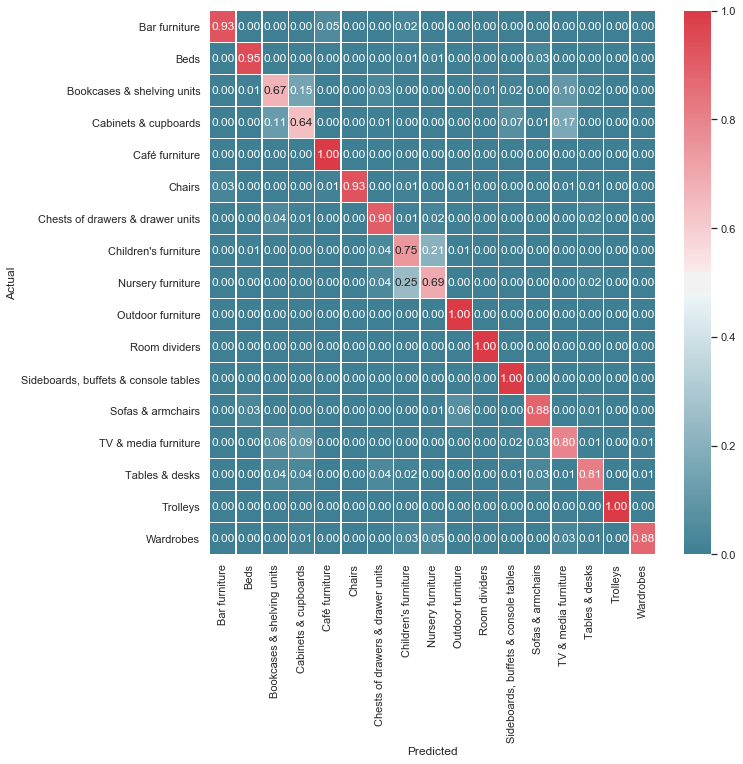

In [80]:
cm = confusion_matrix(y_true = y_test, y_pred=y_pred, labels=label1)

# number of samples actually belong to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((len(label1),len(label1)))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(len(label)):
    cm1[k,:] = cm[k,:]/cm_sum[k]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = label1, columns=label1)

# plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

It seems that by replicating samples for the categories with very few samples, the prediction could be improved significantly. Now, the prediction accuracy is at least 64% for all categories. Still, the prediction for the categories which only had few samples is not as accurate as it is for categories which had a lot of samples such as 'Beds'. However, not all categories perform well just because the data-set included a lot of different samples. An example for that would be category 'Bookcases & shelving units'.\
The prediction works best for the following categories and even reaches an accuracy of  100%: 'Café furniture', 'Outdoor furniture', 'Room dividers', 'Sideboards, buffets &console tables', 'Trolleys'.

In [81]:
# training accuracy 
y_pred_train = tree_est.predict(X_train)
accuracy_train_3 = round(accuracy_score(y_train, y_pred_train),4)
improvement_train = round(((accuracy_train_3-accuracy_train_2)/accuracy_train_3)*100,2)
print(f'Model training accuracy: {accuracy_train_3}.')
if improvement_train >0.0:
    print(f'The training accuracy improved by {improvement_train}%.\n')
elif improvement_train <0.0:
    print(f'The training accuracy deteriorated by {improvement_train}%.\n')
elif improvement_train == 0.0:
    print('No improvement of the training accuracy.\n')
    
# test accuracy
accuracy_test_3 = round(accuracy_score(y_test, y_pred),4)
print(f'Model test accuracy: {accuracy_test_3}.')
improvement_test = round(((accuracy_test_3-accuracy_test_2)/accuracy_test_3)*100,2)
if improvement_test >0.0:
    print(f'The test accuracy improved by {improvement_test}%.\n')
elif improvement_test <0.0:
    print(f'The test accuracy deteriorated by {improvement_test}%.\n')
elif improvement_test == 0.0:
    print('No improvement of the test accuracy.\n')

Model training accuracy: 0.9101.
The training accuracy improved by 5.93%.

Model test accuracy: 0.876.
The test accuracy improved by 11.58%.



### Further Investigations of the Decision Tree

In this next step, we examine how the decision tree performs for different parameter settings. With 'trial and error' first, we iteratively investigate the impact of the following 2 parameters: ``min_samples_split`` and ``min_samples_leaf``. 

The parameter ``'min_samples_split'`` defines the minimum number of samples needed to split the tree. This value was previously set to 20. Now we wil investigate, how this value influences the overall accuracy of the decision tree.

Whereas, the parameter ``min_samples_leaf`` defines the minimal number of samples to be at a leaf node. Thus, split points will only be considered if at least ``min_samples_leaf`` training samples are left in each of the branches.

In [82]:
min_samples_split = [2,4,6,8,10,12,14,16,20,24]
min_samples_leaf = [1,2,3,4,5,6,7]

X_train, X_test, y_train, y_test = test_train_dataset(learn_df_final, predictors, train_size, random_state)

In [83]:
result = []

for min_leaf in min_samples_leaf:    
    for min_split in min_samples_split:
        
        start_time = time.time()

        clf =  tree.DecisionTreeClassifier(min_samples_split = min_split, min_samples_leaf = min_leaf)
        clf.fit(X_train,y_train)
        y_pred =  clf.predict(X_test)

        end_time = time.time() - start_time

        accuracy_test = accuracy_score(y_test, y_pred)
        y_pred_train = tree_est.predict(X_train)
        accuracy_train = accuracy_score(y_train, y_pred_train)

        feature_importances = tree_est.feature_importances_
        feature_importances = pd.DataFrame(data=feature_importances, index=predictors, columns = ['Importance']).sort_values(by=['Importance'], 
                                                                                                                             ascending=False)

        result.append(
            {
                'min_samples_split': min_split,
                'min_samples_leaf': min_leaf ,
                'time': end_time,
                'training accuracy': accuracy_train,
                'test accuracy': accuracy_test,
                'importance': feature_importances
                }
            )

Comparing the time consumption of the different configurations notice, that the more complex the decision tree, the longer the computation time. But, this was to be expected. However, as the time consumption is very low for the Decision Tree Classifier, the computation time will not be taken into account when determining the best parameter combination.

In [98]:
res = pd.DataFrame(result)

accuracy_test =  res['test accuracy'].max()
best_min_split = res.loc[res['test accuracy'].idxmax(), 'min_samples_split']
best_min_leaf = res.loc[res['test accuracy'].idxmax(), 'min_samples_leaf']
accuracy_train = res.loc[res['test accuracy'].idxmax(), 'training accuracy']
time = res.loc[res['test accuracy'].idxmax(), 'time']
    
print(f"The best results are achieved with the following settings:\n\nmin_samples_split: {best_min_split}\nmin_samples_leaf: {best_min_leaf}\n\ntest accuracy: {round(accuracy_test,3)}\ntime consumption: {round(time,3)}")

The best results are achieved with the following settings:

min_samples_split: 4
min_samples_leaf: 1

test accuracy: 0.891
time consumption: 0.026


In this case, we will not check the single confusion matrix again as the data-set now is balanced with respect to the number of samples for each category.

In order to better understand the influence of the parameters ``min_samples_leaf`` and ``min_samples_split`` on the test accuracy, we take a closer look at them on their own.
The  parameter ``criterion`` controlls which function is used to measure the quality of the split. By defaultthe ``criterion`` is the Gini Index. Out of curiosity, lets see how the model performs if we consider the Cross-Entropy as a viable option to measure the quality of a split as well.

In [99]:
results_min_split = []
acc_gini = []
acc_entropy = []

for min_split in min_samples_split:

        # gini
        clf =  tree.DecisionTreeClassifier(min_samples_split=min_split, min_samples_leaf = best_min_leaf, criterion='gini')
        clf.fit(X_train,y_train)
        y_pred =  clf.predict(X_test)
        acc_gini.append(accuracy_score(y_test, y_pred))
        
        # entropy
        clf =  tree.DecisionTreeClassifier(min_samples_split=min_split, min_samples_leaf = best_min_leaf, criterion='entropy')
        clf.fit(X_train,y_train)
        y_pred =  clf.predict(X_test)
        acc_entropy.append(accuracy_score(y_test, y_pred))

  
results_min_split = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
 'acc_entropy':pd.Series(acc_entropy),
 'min_samples_split':pd.Series(min_samples_split)})

In [100]:
results_min_leaf = []
acc_gini = []
max_depth_gini = []
n_leaves_gini = []
acc_entropy = []
max_depth_entropy = []
n_leaves_entropy = []

for min_leaf in min_samples_leaf: 
    
    # gini
    clf =  tree.DecisionTreeClassifier(min_samples_split=best_min_split, min_samples_leaf = min_leaf, criterion = 'gini')
    clf.fit(X_train,y_train)
    y_pred =  clf.predict(X_test)
    acc_gini.append(accuracy_score(y_test, y_pred))
    max_depth_gini.append(clf.tree_.max_depth)
    n_leaves_gini.append(clf.tree_.n_leaves)
    
    # entropy
    clf =  tree.DecisionTreeClassifier(min_samples_split=best_min_split, min_samples_leaf = min_leaf, criterion = 'entropy')
    clf.fit(X_train,y_train)
    y_pred =  clf.predict(X_test)
    acc_entropy.append(accuracy_score(y_test, y_pred))
    max_depth_entropy.append(clf.tree_.max_depth)
    n_leaves_entropy.append(clf.tree_.n_leaves)
    
results_min_leaf = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
 'max_depth_gini':pd.Series(max_depth_gini),
 'n_leaves_gini':pd.Series(n_leaves_gini),
 'acc_entropy':pd.Series(acc_entropy),
 'max_depth_entropy':pd.Series(max_depth_entropy),
 'n_leaves_entropy':pd.Series(n_leaves_entropy),
 'min_samples_leaf':pd.Series(min_samples_leaf)})

Visualize the changes in the test accuracy depending on the parameter setting:

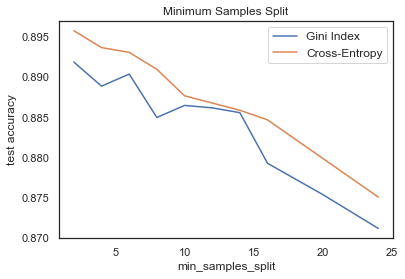

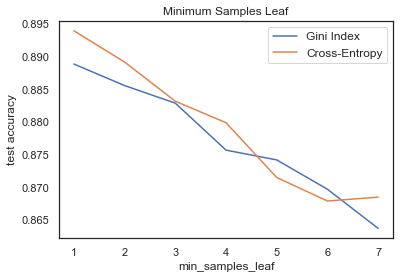

In [101]:
font_size = 12

# visualizing changes in min_samples_split
plt.plot('min_samples_split','acc_gini', data=results_min_split, label='Gini Index')
plt.plot('min_samples_split','acc_entropy', data=results_min_split, label='Cross-Entropy')
plt.xlabel('min_samples_split', fontsize=font_size)
plt.ylabel('test accuracy', fontsize=font_size)
plt.title('Minimum Samples Split', fontsize=font_size)
plt.legend(fontsize=font_size)
plt.show()

# visualizing changes in min_samples_leaf
plt.plot('min_samples_leaf','acc_gini', data=results_min_leaf, label='Gini Index')
plt.plot('min_samples_leaf','acc_entropy', data=results_min_leaf, label='Cross-Entropy')
plt.xlabel('min_samples_leaf', fontsize=font_size)
plt.ylabel('test accuracy', fontsize=font_size)
plt.title('Minimum Samples Leaf', fontsize=font_size)
plt.legend(fontsize=font_size)
plt.show()

``min_samples_split``:\
The highest accuracy can be achieved when using the Cross-Entropy as the criterion and setting the minimum number of samples required to split an internal node to 2. With a higher number of minimum samples the accuracy decreases.\
Generally, when using the Cross-Entropy as the criterion, slightly better results can be achieed than when using the Gini Index. 

``min_samples_leaf``:\
Again, the highest accuracy is achieved when using the Cross-Entropy. However, the Cross-Entropy does not strictily perform better than the Gini Index and for some values of min_samples_leaf, the Gini-Index actually achieves higher accuracies. Note that the smaller the parameter min_samples_leaf, the higher the resulting test accuracy. Still, the best result is achieved for the lowest possible value of min_samples_leaf. 

Although in this example, the highest accuracies are achieved when using the Cross-Entropy as the criterion, in both cases, the best results are received for the default parameter settings:\
``min_samples_split``= 2\
``min_samples_leaf``= 1

In [104]:
max_acc_gini = round(results_min_leaf.acc_gini.max()*100,2)
idx = results_min_leaf['acc_gini'].index.max()
max_depth_gini = results_min_leaf.max_depth_gini[idx]
n_leaves_gini = results_min_leaf.n_leaves_gini[idx]

max_acc_entropy = round(results_min_leaf.acc_entropy.max()*100,2)
idx = results_min_leaf['acc_entropy'].index.max()
max_depth_entropy = results_min_leaf.max_depth_entropy[idx]
n_leaves_entropy = results_min_leaf.n_leaves_entropy[idx]

delta = abs(round((max_acc_gini-max_acc_entropy),2))

if max_acc_gini>max_acc_entropy:
    print(f'The highest accuracy is achieved with the criterion \'gini\': {max_acc_gini}%.\nWith the Gini Index the accuracy is {delta}% higher than with the Cross-Entropy.\n')
    print(f'Tree parameters:\nmax_depth = {max_depth_gini},\nn_leaves = {n_leaves_gini}.')
else:
    print(f'The highest accuracy is achieved with the criterion \'entropy\': {max_acc_entropy}%.\nWith the Cross-Entropy the accuracy is {delta}% higher than with the Gini Index.\n')
    print(f'Tree parameters:\nmin_samples_split=2,\nmin_samples_leaf=1,\nmax_depth = {max_depth_entropy},\nn_leaves = {n_leaves_entropy}.')
    

The highest accuracy is achieved with the criterion 'entropy': 89.39%.
With the Cross-Entropy the accuracy is 0.5% higher than with the Gini Index.

Tree parameters:
min_samples_split=2,
min_samples_leaf=1,
max_depth = 19,
n_leaves = 295.


### Pruning

To overcome the drawback of the previous methodology, we can create a smaller tree with
fewer splits. This might lead to lower variance and allow a better interpretation at the cost of a little bias. By default, no pruning is performed. However, with the parameters provided for the Decision Tree Classifier (e.g. ``min_samples_leaf``)  overfiting can be prevented. The influence of those parameters on the Decision Tree was already explored earlier.
 
The goal of pruning is to select a subtree leading to the lowest test error rate. However, it is rather complicated to consider every possible subtree.
In a first step, the parameter ``max_depth``is investigated in more detail. Thereafter, we try to improve the decision tree with cost complexity pruning.

#### Investion of the depth of the Decision Tree using ``max_depth``

The parameter ``max_depth`` controls the depth of the trees. By default ``max_depth``is set to 'None'. In that case, the nodes are expanded until all leaves are pure **or** until all leaves contain less than min_samples_split samples.\
In the following, it is investigated how simple changes in ``max_depth`` impact the tree. Ideally, a smaller tree can be created with a sufficent accuracy.

In [105]:
max_depth = []
acc_gini = []
acc_entropy = []

X_train, X_test, y_train, y_test = test_train_dataset(learn_df_final, predictors, train_size, random_state)

for i in range(1,30):
    
    max_depth.append(i)
    
    clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)  
    acc_gini.append(accuracy_score(y_test, y_pred))
    
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_entropy.append(accuracy_score(y_test, y_pred))

d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
 'acc_entropy':pd.Series(acc_entropy),
 'max_depth':pd.Series(max_depth)})

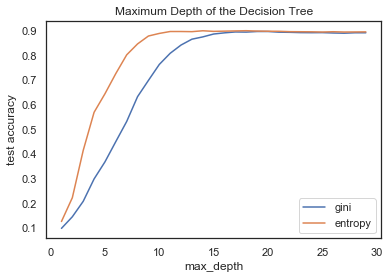

In [106]:

plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('test accuracy')
plt.title('Maximum Depth of the Decision Tree')
plt.legend()
plt.show()

With an increasing depth, the test accuracy can be increased as well. Again, using the Cross-Entropy as the crtierion results in slightly higher test accuracies. However, with a max_depth greater or equal to 15, both criterions perform similarly good.

#### Cost Complexity Pruning

Another option is to apply 'cost complexity pruning'. Here, a sequence of trees is considered instead of all the possibilities. The pruning decision is made based on the value of the cost complexity parameter ``ccp_alpha``. In each iteration, the subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. The greater the cost complexity paramater ``ccp_alpha`` the higher the number of nodes that are pruned, which increases the total impurity of its leaves.\
Applying cost complexity pruning we followed an example published on Scikit-Learn.


In a first step, the Decision Tree Classifier is trained. Then the cost_complexity values are retrieved.

In [91]:
X_train, X_test, y_train, y_test = test_train_dataset(learn_df_final, predictors, train_size, random_state)

clf = tree.DecisionTreeClassifier(criterion='gini')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test) 

ccp_path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas= ccp_path.ccp_alphas
impurities = ccp_path.impurities

Then the total impurity is plotted over alpha for the training set:

Text(0.5, 1.0, 'Total impurity vs. cost complexity parameter alpha for training set')

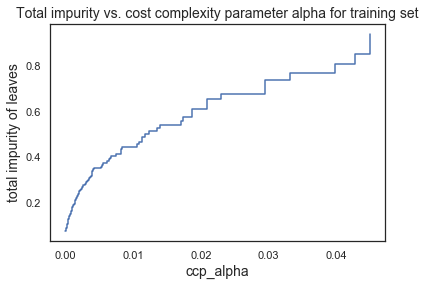

In [111]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas, impurities, drawstyle="steps-post")
ax.set_xlabel("ccp_alpha",fontsize=14)
ax.set_ylabel("total impurity of leaves",fontsize=14)
plt.title("Total impurity vs. cost complexity parameter alpha for training set",fontsize=14)

The larger ccp_alpha, the larger the impurity. For the largest alpha, naturally, the impurity is one.

Next, the decision tree is trained using the alpha-values that were determined earlier. The parameter ``criterio`` was set to 'entropy' since our previous investigations proved the Cross-Entropy to result in higher accuracies than the Gini Index. As for the parameters ``min_samples_leaf`` and ``min_samples_split``, the best results were achieved with their default values 1 and 2, respectively.\

*Note: Since some values in 'ccp_alphas' are very small negatives. However, per definition alpha can only take values that are greater or equal to zero. Therefore, very small but negative alphas will be set to 0 in the follwoing in order to avoid errors.*

In [93]:
clfs = []
criterion = 'entropy'
for ccp_alpha in ccp_alphas:
    if round(ccp_alpha,10)==0: 
        ccp_alpha = 0
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, criterion = criterion)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, round(ccp_alphas[-1],4)))

Number of nodes in the last tree is: 37 with ccp_alpha: 0.0449


Now, visualize the number of nodes and the tree depth over alpha:

Text(0.5, 1.0, 'Maximum depth of the tree')

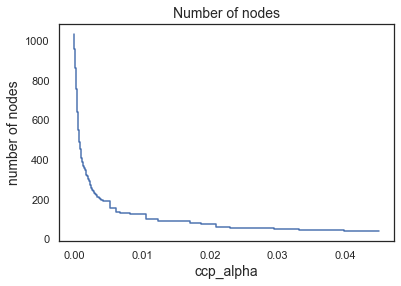

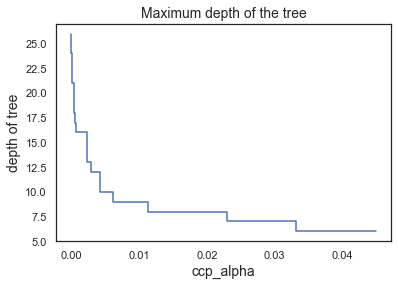

In [112]:
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig1, ax1 = plt.subplots()
ax1.plot(ccp_alphas, node_counts, drawstyle="steps-post")
ax1.set_xlabel("ccp_alpha",fontsize=14)
ax1.set_ylabel("number of nodes",fontsize=14)
ax1.set_title("Number of nodes",fontsize=14)

fig2, ax2 = plt.subplots()
ax2.plot(ccp_alphas, depth, drawstyle="steps-post")
ax2.set_xlabel("ccp_alpha",fontsize=14)
ax2.set_ylabel("depth of tree",fontsize=14)
ax2.set_title("Maximum depth of the tree",fontsize=14)

Both, the number of nodes and the depth decrease with an increasing alpha.

Comparing the training and test accuracies depending on the current alpha:

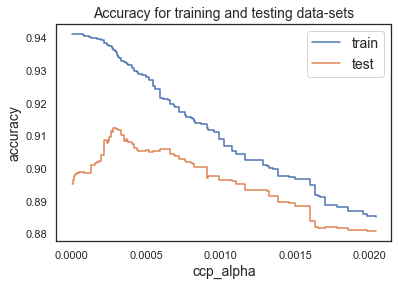

In [95]:
test_acc = [clf.score(X_test, y_test) for clf in clfs if clf.score(X_test, y_test)>0.88]
train_acc= [clf.score(X_train, y_train) for clf in clfs if clf.score(X_test, y_test)>0.88]
#train_acc = [clfs[i].score(X_train, y_train) for i in range(len(test_acc))]
ccp_alphas_train = ccp_alphas[0:len(test_acc)]
ccp_alphas_test = ccp_alphas[0:len(test_acc)]

fig, ax = plt.subplots()
ax.set_xlabel("ccp_alpha", fontsize=14)
plt.xticks(np.arange(0, round(max(ccp_alphas_train),5), step=0.0005))
ax.set_ylabel("accuracy", fontsize=14)
ax.set_title("Accuracy for training and testing data-sets", fontsize = 14)
ax.plot(ccp_alphas_train, train_acc, label="train",drawstyle="steps-post")
ax.plot(ccp_alphas_test, test_acc, label="test", drawstyle="steps-post")
ax.legend(fontsize=14)
plt.show()

In [96]:
max_test_acc = max(test_acc)
max_ccp_alpha = ccp_alphas_test[test_acc.index(max(test_acc))]
print(f'The maximum test accuracy of {round(max_test_acc,4)*100}% is achieved for ccp_alpha = {round(max_ccp_alpha,5)} with the {criterion}-criterion.\n')
print(f'Tree parameters:\nmax_depth = {clf.tree_.max_depth},\nn_leaves = {clf.tree_.n_leaves}.')

The maximum test accuracy of 91.22% is achieved for ccp_alpha = 0.00028 with the entropy-criterion.

Tree parameters:
max_depth = 6,
n_leaves = 19.


Through cost complexity pruning we were able to improve the accuracy by almost **2%**. The depth of the tree could be reduced from 19 to 8 and the number of leaves from 294 to 44 resulting in a significantly smaller tree than before pruning. 

If we visualize the tree, we notice that it looks very different compared to the last version. Because the tree is still quite large, only the first couple of splittings are displayed.

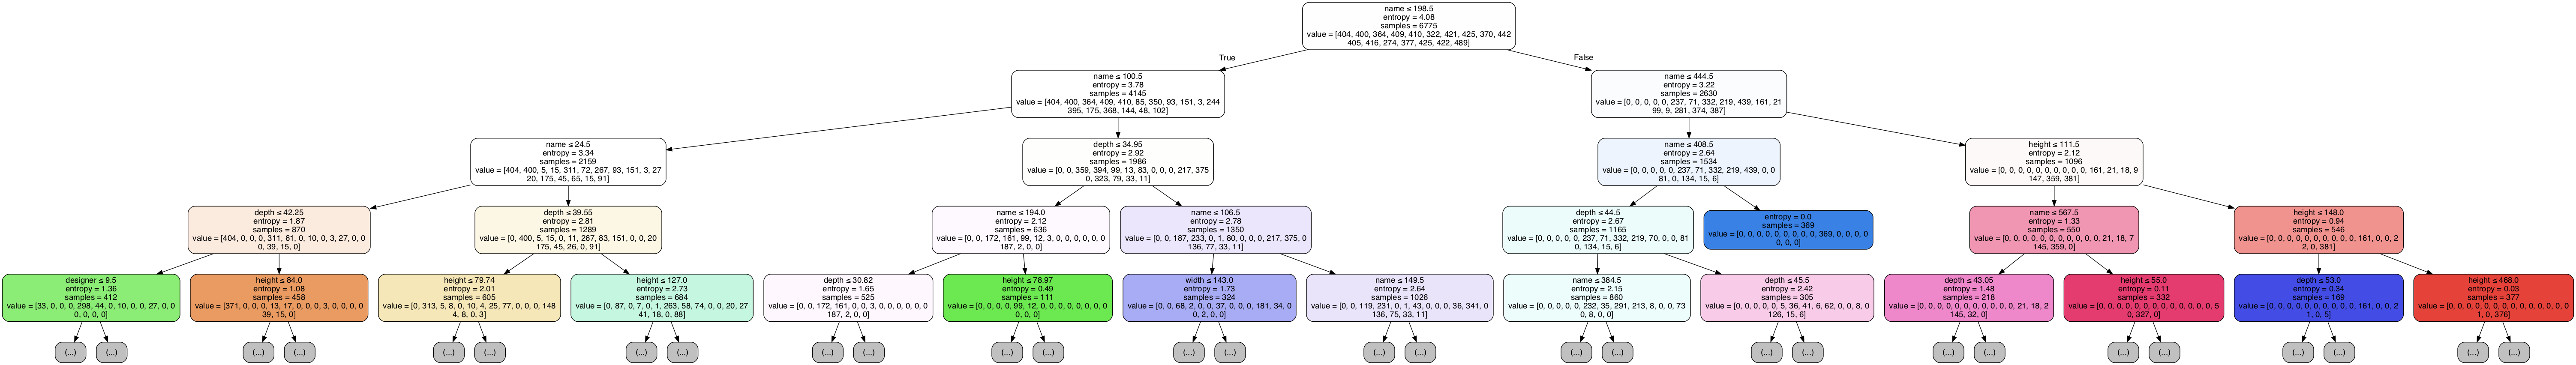

In [97]:
clf = clfs[test_acc.index(max(test_acc))]
tree_est = clf.fit(X_train, y_train)
dot_data = tree.export_graphviz(tree_est, out_file='decision_tree_pruning.dot',feature_names=predictors, 
                filled=True, rounded=True, special_characters=True, precision = 2, max_depth = 4) 



with open('decision_tree_pruning.dot') as f:
    dot_graph = f.read()  

I = graphviz.Source(dot_graph, format='png', engine='dot')
Image(I.render())
#I.view()

## Random Forest

In an effort to overcome the drawbacks of the Decision Tree Classifier and create more powerful models, Random Forest is tested. Random Forests use trees as building blocks. Furthermore, only a subset of features is used. As a result, the problems of overfitting can be reduced and the results tend to generalise better than Decision Trees.
Another advantage of Random Forests is that they can decorrelate the trees.

In order to reduce variance and increase the prediction accuracy, the n trees of the forest are built using bootstrapped training samples. The number of predictors is also bootstraped from the feature cadidates to reduce the correlation between each tree that belongs to the Random Forest.

## Create a Random Forest

For this first step, we take a look at an example classifier. This example classifier is almost a standard random forest classifier except that the parameter ``min_samples_leaf`` is set to 5.

In [113]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import time

### Create a First Version of a Random Forest

In a first step, the data-set 'learn_df' is split into a test and training data-set. After fitting the random forest classifier to the training data-set and then use the test data-set to test the model. 

In [114]:
X_train, X_test, y_train, y_test = train_test_split(learn_df.drop(columns = ['category','category_num']), \
                                                    learn_df['category_num'], train_size=0.67, random_state=1)

rf =  RandomForestClassifier(min_samples_leaf= 5)
rf_est = rf.fit(X_train,y_train)
y_pred =  rf.predict(X_test)

a = accuracy_score(y_test, y_pred)
print(f'Overall accuracy for this first model: {round(a*100,4)}%.')

Overall accuracy for this first model: 80.8197%.


*Note : This overall acuracy is not weighted by sample size , so even for a category with a small size where the performance is really bad, we still have an acceptable overall accuracy.*

#### Evaluation of this First Version of a Random Forest

In order to evaluate the performance of this first random forst model, the importance of the individual features is compared.

In [115]:
feature_impo = pd.Series(data=rf_est.feature_importances_, index=list(X_train.columns))
feature_impo = feature_impo.sort_values(axis=0, ascending=False)

Text(0.5, 1.0, 'Feature importance')

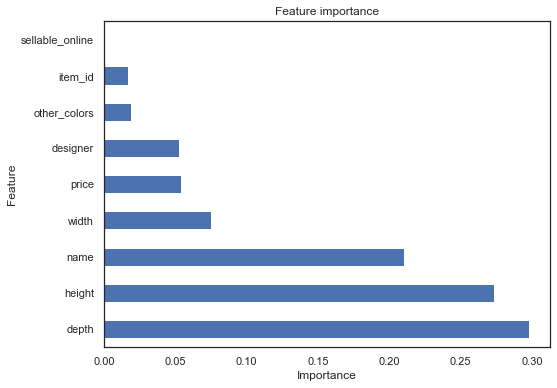

In [116]:
figip,axip = plt.subplots(1,1, figsize=(8,6))
feature_impo.plot(kind='barh', ax=axip)
axip.set_xlabel('Importance')
axip.set_ylabel('Feature')
axip.set_title('Feature importance')

The bar-graph shows the importance of the individual features in increasing order. The most important features are 'depth' and 'height' with approx. 30% and 26%, respectively. As expected, again, sellable_online does not have any importance.   

Now lets check the confusion matrix to examine the accuracy for the individual categories:

In [117]:
cm =  confusion_matrix(y_test, y_pred)

# number of samples actually belong to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((17,17))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(17):
    cm1[k,:] = cm[k,:]/cm_sum[k]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = label, columns=label)

Text(66.45312499999999, 0.5, 'Actual')

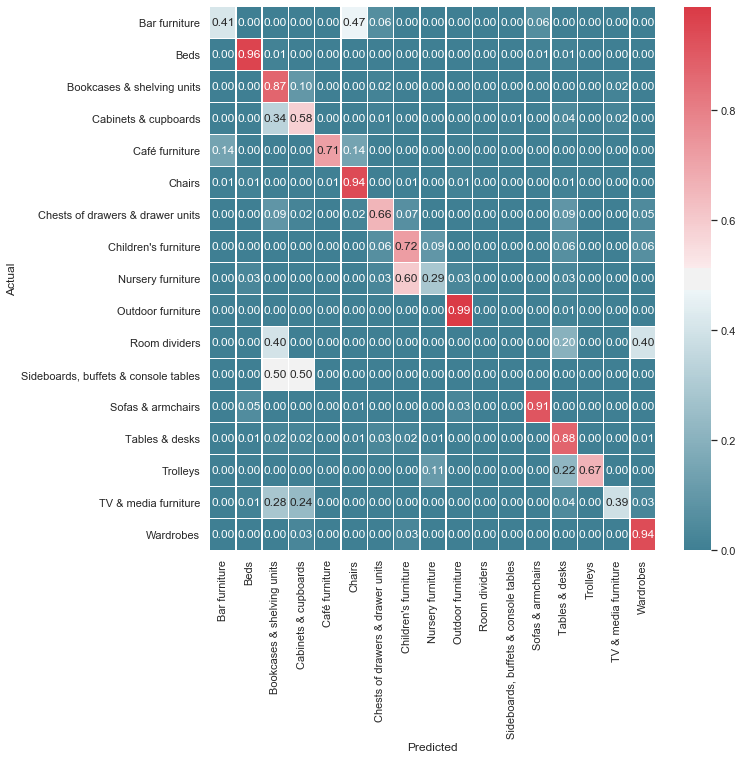

In [118]:
#plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

An analysis of this confusion matrix will be given later, toghether with the next plot.

### First Improvements of the Random Forest
As a first improvement features with a low importance will be excluded from the set of predictors, instead only the features with a higher importance are kept.
From the feature importance report we get that the size-data  plays an important role in the prediction of the category. The feature 'name' is also of significance. Let's see what happens if we just keep features with an importance greater than 5%. Thus, the features 'sellable online', 'item_id' and 'other_colors' are removed from the set of predictors.

In [119]:
learn1 = ['item_id','height','depth','width','name','designer','category','category_num']
learn_df1 = learn_df[learn1]

Again, the data-set is split into a training and test data-set. Then, the Random Forest is trained and tested again.

In [120]:
X_train, X_test, y_train, y_test = train_test_split(learn_df1.drop(columns = ['item_id','category','category_num']), \
                                                    learn_df1['category_num'],train_size=0.67, random_state=1)

rf =  RandomForestClassifier(min_samples_leaf= 5)
rf_est = rf.fit(X_train,y_train)
y_pred =  rf.predict(X_test)
a2 = accuracy_score(y_test, y_pred)
if a<a2:
    print(f'The overall accuracy increased from {round(a*100,2)}% to {round(a2*100,2)}% by {round((a2-a)*100,2)}%.')
else:
    print(f'The overall accuracy decreased from {round(a*100,2)}% to {round(a2*100,2)}% by {round((a2-a)*100,2)}%.')

The overall accuracy increased from 80.82% to 81.31% by 0.49%.


Text(66.45312499999999, 0.5, 'Actual')

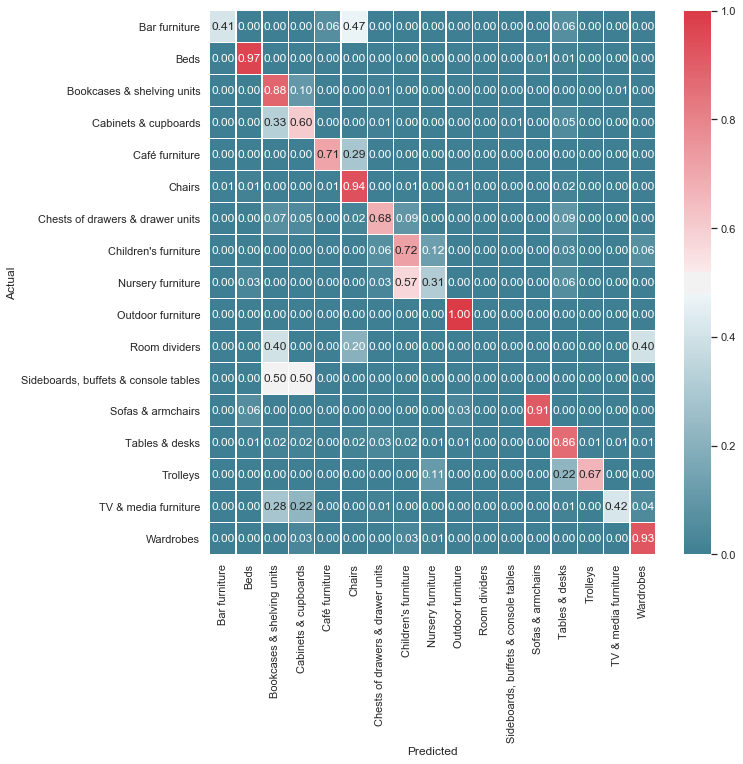

In [121]:
cm =  confusion_matrix(y_test, y_pred)

# number of samples actually belonging to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((17,17))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(17):
    cm1[k,:] = cm[k,:]/cm_sum[k]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = label, columns=label)

#plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

Comparing both, the confusion matrix of the first model and the confusion matrix after this first improvements we can see that through feature selection,  we were able to increase the overall accuracy of approx. 1%.\
Despite the increase in the overall accuracy, the accuracies of some individual categories improved even more. E.g. the accuracy for category 'Nursury furniture' could be increased by approx. 10%.\
However, for some categories, the performance is still really bad. This is especially the case for the following 2 categories: 'Room dividers' with 0%, 'Sideboards & console tables' with 0%. These are also the categories with the fewest data-samples compared to the other categories. As mentioned earlier, we can replicate some samples to create a relatively balanced multi-class classification task.\
Further, the category 'TV & media furniture' does not perform well either as 30% of the items belonging to the category 'TV & media' were instead assigned to the category 'Book cases & shelving units'. Recalling the feature importance and the boxplots from 'height' and 'depth', we find, that those two categories have a very simillar distribution which would explain this mix up. To our supprise, the category 'Trolleys' which has a very small sample size of just 28 performs extremely well. However, this seems not to result from its size-data or the price. However, it seems that the names and designer are restricted for the category 'Trolleys', which might explain the high accuracy for this category.

### Final Version of the Random Forest
For this final Version of the Random Forest we tried to improve the results by replicating samples for the categories with a very small sample size. The goal was to create a relatively balanced classification task by doing so. For the following categories, samples were replicated: 'Room dividers' and 'Sideboards, buffets & console tables'.

In [122]:
size_df = learn_df1.groupby('category').size().reset_index(name='size')
print('Recall the sample size of the different categories:')
size_df

Recall the sample size of the different categories:


,category,size
0,Bar furniture,47
1,Beds,208
2,Bookcases & shelving units,548
3,Cabinets & cupboards,292
4,Café furniture,26
5,Chairs,481
6,Chests of drawers & drawer units,125
7,Children's furniture,124
8,Nursery furniture,97
9,Outdoor furniture,216


*Note: Careful, here the order of the labels changed compared to the list 'label' above. Thus, we cannot use the list 'label' to display the correct order of column names in this section. Therefore, a new list with the correct order of labels was created: 'label1'.*

In [123]:
label1 =size_df['category'].tolist()
if label != label1:
    print('label does not equal label1. Therefore label1 will be used in the following.')

label does not equal label1. Therefore label1 will be used in the following.


In [124]:
label_size = size_df['size'].tolist()
learn_df2 = learn_df1.copy() 

for k in range(17):
    temp_df = learn_df1[learn_df1['category'].str.contains(label1[k])] 
    tt = round(max(label_size)/label_size[k]) -1
    if tt > 0:
        temp_df1 = pd.concat([temp_df]*tt, ignore_index=True)
        learn_df2 = pd.concat([learn_df2, temp_df1] , ignore_index=True)

Recall the sample-size of the categoires before:

In [125]:
size_df

,category,size
0,Bar furniture,47
1,Beds,208
2,Bookcases & shelving units,548
3,Cabinets & cupboards,292
4,Café furniture,26
5,Chairs,481
6,Chests of drawers & drawer units,125
7,Children's furniture,124
8,Nursery furniture,97
9,Outdoor furniture,216


And after replicating samples:

In [126]:
size_df2 = learn_df2.groupby('category').size().reset_index(name='size')
size_df2

,category,size
0,Bar furniture,611
1,Beds,624
2,Bookcases & shelving units,548
3,Cabinets & cupboards,584
4,Café furniture,624
5,Chairs,481
6,Chests of drawers & drawer units,625
7,Children's furniture,620
8,Nursery furniture,582
9,Outdoor furniture,648


Now that the data-set has been modified, the samples are relatively balanced. 

In a next step, the final version of the random forest can be created. However, it is important to keep in mind that the data-set now contains many duplicates for the categories that previously only had very few samples.

In [127]:
X_train, X_test, y_train, y_test = train_test_split(learn_df2.drop(columns = ['item_id','category','category_num']), \
                                                    learn_df2['category_num'],train_size=0.67, random_state=1)
rf =  RandomForestClassifier(min_samples_leaf= 5)
rf_est = rf.fit(X_train,y_train)
y_pred =  rf.predict(X_test)
a3 = accuracy_score(y_test, y_pred)
if a2<a3:
    print(f'Despite the replicated samples, we were able to increase the overall accuracy from {round(a2*100,2)}% to {round(a3*100,2)}% by {round((a3-a2)*100,2)}%.')
else:
    print(f'The overall accuracy decreased from {round(a2*100,2)}% to {round(a3*100,2)}% by {round((a3-a2)*100,2)}%.')

Despite the replicated samples, we were able to increase the overall accuracy from 81.31% to 89.45% by 8.14%.


Text(66.45312499999999, 0.5, 'Actual')

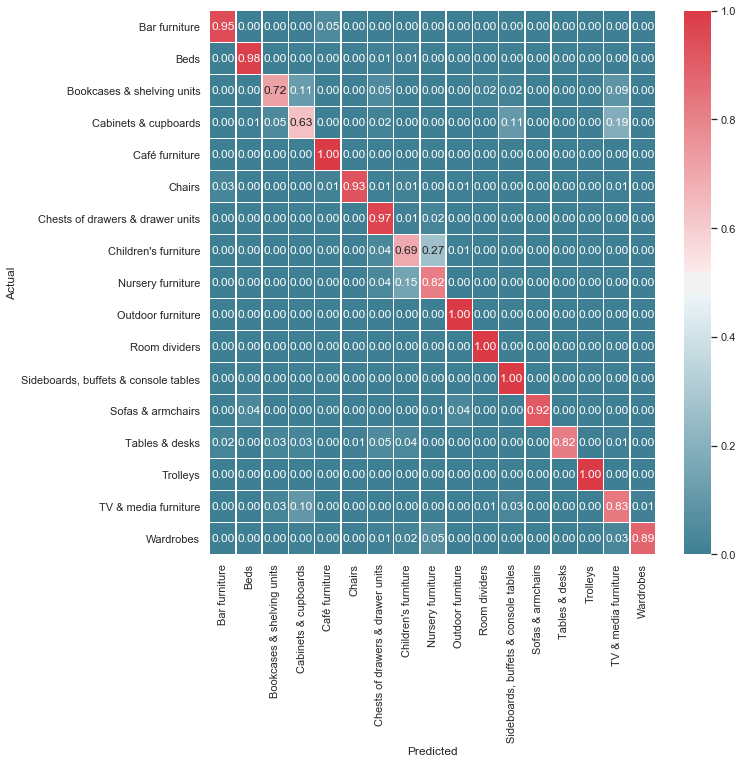

In [128]:
cm =  confusion_matrix(y_test, y_pred)

# number of samples actually belong to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((17,17))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(17):
    cm1[k,:] = cm[k,:]/cm_sum[k]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = label, columns=label)

#plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

Now, we have an almost perfect diagonal matrix as was desired. Through repeating samples the prediction accuracy for 'Bar funiture' could be increased from 42% to 95%, for 'Room dividers' from 0% to 100%, for 'Sideboards and buffets & console tables' from 0% to 100%. It is still hard for the algorithm to distinguish the categories 'nursery furniture' and 'children furniture'. The reason for that could be two very the immportant features: height and depth as the distribution of those features is almost the same in the boxplot for the categories 'nursery furniture' and 'children furniture'.  

In [129]:
feature_impo = pd.Series(data=rf_est.feature_importances_, index=list(X_train.columns))
feature_impo = feature_impo.sort_values(axis=0, ascending=False)
feature_impo

name        0.301407
depth       0.270520
height      0.250404
width       0.100701
designer    0.076967
dtype: float64

Now, with the data-set containing  replicated samles, the feature 'name' becomes the most important feature, followed by 'height' (former top1) and 'depth' (former top2).

### Further Investigations of the Random Forest Model

In this last step we test different parameter settings to see if we can improve our model and get better predictions. Using 'trial and error', we investigate the following parameter sets to better understand the influence of those parameters on the model accuracy: ``n_tree`` and ``min_leaf``.

In [130]:
n_tree = [20,40,60,100,200,400,600,1000,1200,1400]
min_leaf = [1,3,5,7,9,13]

In [131]:
def RandomForest(n_tree, min_leaf, learn_df):
    
    X_train, X_test, y_train, y_test = train_test_split(learn_df2.drop(columns = ['category_num','category','item_id']), \
                                                        learn_df2['category_num'], random_state=1)
    start_time = time.time()
    rf =  RandomForestClassifier(n_estimators = n_tree,criterion = 'gini', min_samples_leaf = min_leaf,random_state =1,\
                                 oob_score=True,warm_start=True)
    rf.fit(X_train,y_train)
    y_pred =  rf.predict(X_test)
    end_time = time.time()
    
    a = accuracy_score(y_test, y_pred)
    oob = rf.oob_score_
    return a, oob

In [132]:
y1 = []
for l in range(len(min_leaf)):
    a, oob = RandomForest(100, min_leaf[l],learn_df2)
    y1.append((a,oob)) 

The best result is achieved if min_samples_leaves equals 1 (before it was set to 5). If we increase the number of trees, the overall predictions accuracy decreases. Normally, the acurracy increases with the forest size until it reaches a certain threshold and the accuracy becomes stable. Overall, the parameters only influence the overall acuracy by less than 0.01. The 'new' best overall accuracy for the random forest is approx. 90%. The parameter setting is the following:\
``minimum_samples_leaf`` = 1,\
``n_tree`` = 400.

Here we won't check the single confusion matrix, since the data-set is now balanced with respect to the sample size of the individual categories. 

Text(0.5, 0, 'min_samples_leaf')

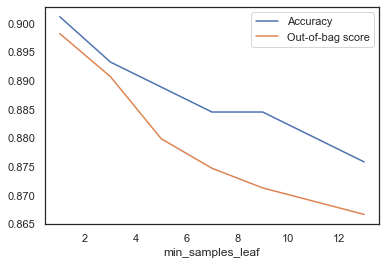

In [133]:
plt.plot(min_leaf,y1)
plt.legend( ['Accuracy','Out-of-bag score'])
plt.xlabel("min_samples_leaf")

The figure above shows that the larger we set the parameter min_samples_leaf, the larger the gap between the accuracy and the out of bag score gets. This indicates that the model is not fitted as well to the data-set anymore.

In [134]:
y2 = []
for i in range(len(n_tree)):
    a, oob = RandomForest(n_tree[i], 1,learn_df2)
    y2.append((a,oob)) 

/Users/alissaganter/opt/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/alissaganter/opt/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Text(0.5, 0, 'n_tree')

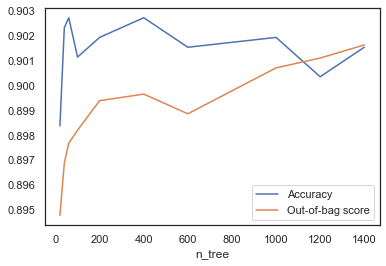

In [135]:
plt.plot(n_tree,y2)
plt.legend( ['Accuracy','Out-of-bag score'])
plt.xlabel("n_tree")

As we can see in the plot above, the larger the forest is, the smaller is the gap between the OOB score and the accuracy. In other words, the smaller the gap between the OOB score and the accuracy, the better the fit of classifier and data.

## Boosting

In [136]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import time

### Test and Training Data-sets

In a first step, the dataset 'learn_df' is split into a test- and training-dataset. The predictors for this first model will be the follwing features: 'item_id', 'name', 'price', 'sellable_online', 'other_colors', 'designer', 'depth', 'height', 'width'. Then the model can be trained and first predictions can be made.

In [137]:
#get unique labels of data
labels = IKEA_df['category'].unique()

# split the data into test and training data-set
X_train, X_test, y_train, y_test = train_test_split(learn_df.drop(columns = ['category','category_num']), \
                                                    learn_df['category_num'], train_size=0.67, random_state=1)

### First Version of the Boosting

We are exploring the method of Boosting in order to classify the IKEA Furniture Data-Set. For performance tests we will use the default parameters such as ``loss`` = deviance, ``learning_rate`` = 0.1, ``n_estimators`` = 100 and ``max_depth`` = 3. The parameter ``criterion`` is by default the friedman_mse. Random splitting was not investigated in this context. As a last step, we will further investigate the influence of some parameters on our model.

In [138]:
booster = GradientBoostingClassifier()

In [139]:
boost_est = booster.fit(X_train, y_train)

y_pred = boost_est.predict(X_test)

#### Evaluation of this First Version

In [140]:
predictors = learn_df.columns.tolist()
predictors.remove('category')
predictors.remove('category_num')

feature_importances = boost_est.feature_importances_
features = pd.DataFrame(data=feature_importances, index=predictors, columns = ['Importance']).sort_values(by=['Importance'], 
                                                                                                ascending=False)
features

,Importance
depth,0.393895
name,0.246382
height,0.245704
width,0.040372
price,0.027258
designer,0.026022
item_id,0.015123
other_colors,0.005062
sellable_online,0.000183


As the table shows, the most important features are  'depth' (approx. 40%) ,'name' (approx. 25%), and 'heigth' (approx. 25%). Other features such as 'price', 'item_id' or 'designer' account for less than 3%. As was suspected earlier when analyzing the raw-data, the feature 'sellable_online' does not have any importance as almost all products are sellable online. It is similar for the feature 'other_colors' as most items are available in different colors. On the contrary, 'item_id' is unique for the vast majority of items, therefore the feature 'item_id' is not a good indicator for the item category as well, resulting in a low importance of the feature.

In a next step the confusion matrix is created and the training and test accuracy are computed.

Text(66.45312499999999, 0.5, 'Actual')

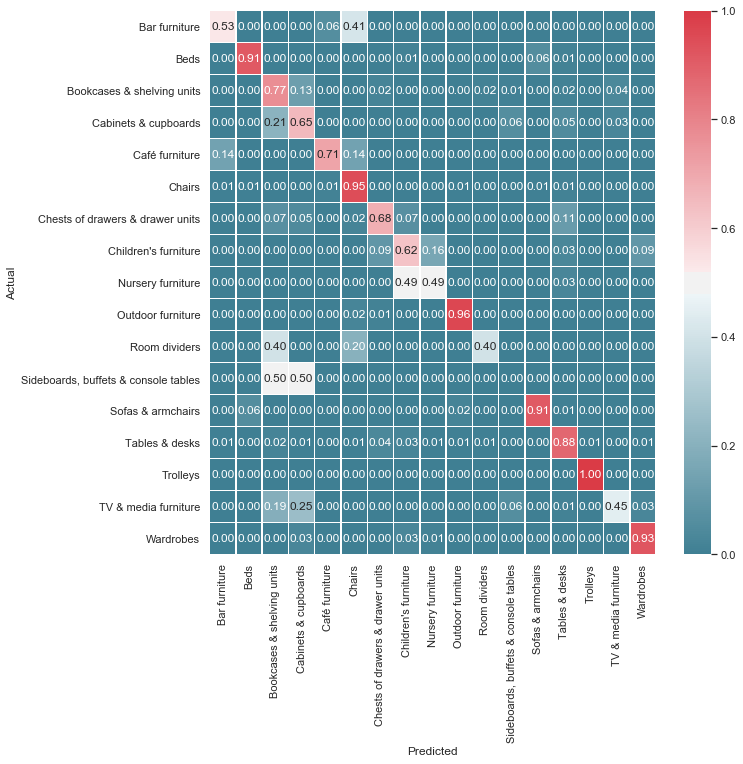

In [141]:
cm =  confusion_matrix(y_test, y_pred)

# number of samples actually belong to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((len(cm),len(cm)))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(len(y_test.unique())):
    cm1[k,:] = cm[k,:]/cm_sum[k]

cm1 = cm1[0:len(y_test.unique()), 0:len(y_test.unique())]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = labels, columns=labels)


#plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

If we look at the confusion matrix, we see that we have problems to classify some categories such as 'Bar furniture' or 'Room dividers'. Additionally we were not able to classify 'Sideboards, buffets & console tables' correctly at all. Due to these classification errors we need do improve our model. 

In [142]:
# determine training accuracy 
y_pred_train = boost_est.predict(X_train)

# determine test accuracy
accuracy_test_1 = accuracy_score(y_test, y_pred)
print("Model test accuracy:", round(accuracy_test_1,4))

Model test accuracy: 0.8074


### First Improvements of Boosting

As a first attempt to improve the model, all features with an importance of less than 3% are excluded from the set of predictors. This is the case for the following features: 'Price', 'Item_id', 'Designer', 'Other_colors' and 'Sellable_online'. For that, adjust the dataframe which is used to create the training and test dataset and then fit the data for boosting ('learn_df_improvement').

In [143]:
learn = ['height','depth','width','name','category','category_num']
learn_df_improvement = learn_df[learn]

In [144]:
X_train, X_test, y_train, y_test = train_test_split(learn_df_improvement.drop(columns = ['category','category_num']), \
                                                    learn_df_improvement['category_num'], train_size=0.67, random_state=1)

In [145]:
booster = GradientBoostingClassifier()

In [146]:
boost_est = booster.fit(X_train, y_train)

y_pred = boost_est.predict(X_test)

#### Evaluation of this Second Version

In [147]:
predictors = learn_df_improvement.columns.tolist()
predictors.remove('category')
predictors.remove('category_num')

feature_importances = boost_est.feature_importances_
features = pd.DataFrame(data=feature_importances, index=predictors, columns = ['Importance']).sort_values(by=['Importance'], 
                                                                                                ascending=False)
features

,Importance
depth,0.410188
name,0.277061
height,0.258885
width,0.053866


As the table shows, all of the features account for more than 5% of the prediction.

In a next step the confusion matrix is created and the training and test accuracy are computed.

Text(66.45312499999999, 0.5, 'Actual')

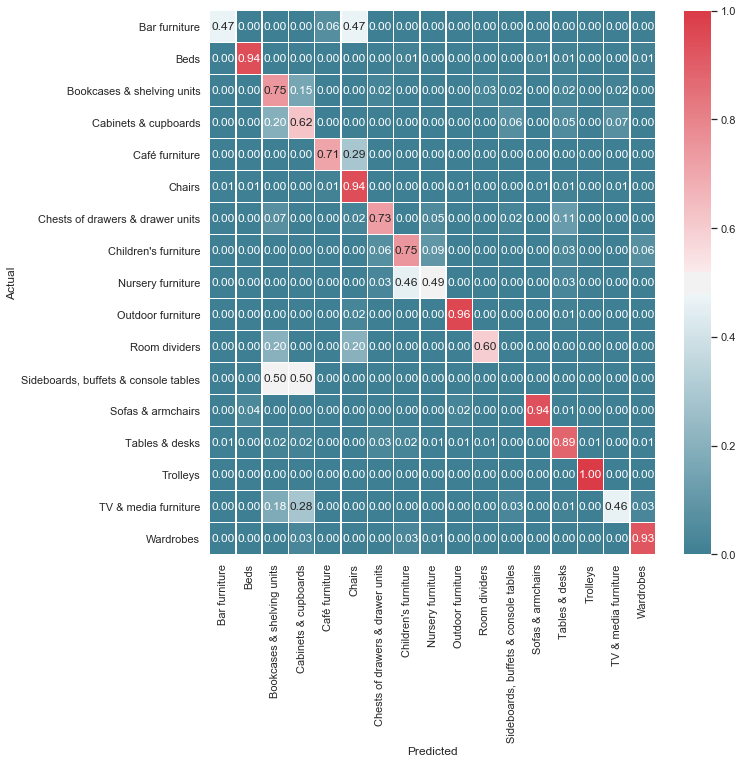

In [148]:
cm =  confusion_matrix(y_test, y_pred)

# number of samples actually belong to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((len(cm),len(cm)))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(len(y_test.unique())):
    cm1[k,:] = cm[k,:]/cm_sum[k]

cm1 = cm1[0:len(y_test.unique()), 0:len(y_test.unique())]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = labels, columns=labels)


#plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

If we look at the confusion matrix, we see that for some classes we have lost a little bit of predictive power. However, we have been able to improve the overall predictability. But we were still unable to classify 'Sideboards, buffets & console tables' correctly at all. Due to these classification errors we need to further improve our model. 

In [149]:
# determine training accuracy 
y_pred_train = boost_est.predict(X_train)
accuracy_train_2 = accuracy_score(y_train, y_pred_train)
improvement_train = round(((accuracy_train_2-accuracy_train_1)/accuracy_train_2)*100,2)
print("Training accuracy:", round(accuracy_train_2,4))
if improvement_train >0.0:
    print("The training accuracy improved by " +str(improvement_train)+ "%.\n")
elif improvement_train <0.0:
    print("The training accuracy deteriorated by " +str(improvement_train)+ "%.\n")
elif improvement_train == 0.0:
    print("No improvement of the training accuracy.")

# determine test accuracy
accuracy_test_2 = accuracy_score(y_test, y_pred)
print("Test accuracy:", round(accuracy_test_2,4))
improvement_test = round(((accuracy_test_2-accuracy_test_1)/accuracy_test_2)*100,2)
if improvement_test >0.0:
    print("The test accuracy improved by " +str(improvement_test)+ "%.\n")
elif improvement_test <0.0:
    print("The test accuracy deteriorated by " +str(improvement_test)+ "%.\n")
elif improvement_test == 0.0:
    print("No improvement of the test accuracy.\n")

Training accuracy: 0.9163
The training accuracy improved by 6.13%.

Test accuracy: 0.8115
The test accuracy improved by 0.51%.



### Final Version of Boosting

In the data analysis we found, that the sample size varies depending on the category. We noticed that especially for those categories, that have fewer samples, the decision tree performs poorly. In an effort to balance the sample size of categories with very few samples, some samples were replicated. Recall the sample size of the individual categories:


In [150]:
size_df = learn_df_improvement.groupby('category').size().reset_index(name='size')
size_df

,category,size
0,Bar furniture,47
1,Beds,208
2,Bookcases & shelving units,548
3,Cabinets & cupboards,292
4,Café furniture,26
5,Chairs,481
6,Chests of drawers & drawer units,125
7,Children's furniture,124
8,Nursery furniture,97
9,Outdoor furniture,216


Remeber the confusion matrix after the first improvments: The prediction accuracy of the categories 'Sideboards, buffets & console tables', 'Room dividers' was significantly lower than for the other categories. Both categories have a very low number of samples compared to other categories such as 'Beds' where the prediction accuracy was 90%

In [151]:
label1 =size_df['category'].tolist()

if label!=label1:
    print('The column order changed. Therefore, we will have to use label1 in the following.')

The column order changed. Therefore, we will have to use label1 in the following.


In [152]:
learn_df_final = learn_df_improvement.copy(deep=True)

In [153]:
label_size = size_df['size'].tolist()
for k in range(len(label1)):
    temp_df = learn_df_improvement[learn_df_improvement['category'].str.contains(label1[k])] 
    tt = round(max(label_size)/label_size[k]) -1
    if tt > 0:
        temp_df_improvement = pd.concat([temp_df]*tt, ignore_index=True)
        learn_df_final = pd.concat([learn_df_final, temp_df_improvement] , ignore_index=True)

In [154]:
size_df_final = learn_df_final.groupby('category').size().reset_index(name='size')
size_df_final

,category,size
0,Bar furniture,611
1,Beds,624
2,Bookcases & shelving units,548
3,Cabinets & cupboards,584
4,Café furniture,624
5,Chairs,481
6,Chests of drawers & drawer units,625
7,Children's furniture,620
8,Nursery furniture,582
9,Outdoor furniture,648


By replicating samples for some categories, the number of samples of the dataset now is relatively balanced. However, note that by replicating samples now the categories which were lacking samples before now contain many duplicate samples.

In [155]:
X_train, X_test, y_train, y_test = train_test_split(learn_df_final.drop(columns = ['category','category_num']), \
                                                    learn_df_final['category_num'], train_size=0.67, random_state=1)

In [156]:
booster = GradientBoostingClassifier()

In [157]:
boost_est = booster.fit(X_train, y_train)

y_pred = boost_est.predict(X_test)

#### Evaluation of this Final Version

Text(66.45312499999999, 0.5, 'Actual')

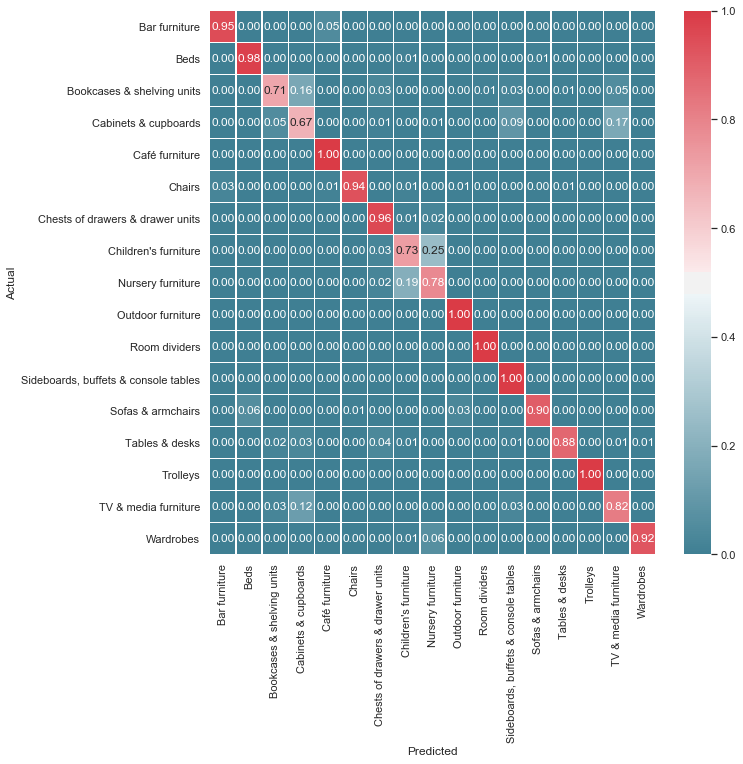

In [158]:
cm =  confusion_matrix(y_test, y_pred)

# number of samples actually belong to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((len(cm),len(cm)))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(len(y_test.unique())):
    cm1[k,:] = cm[k,:]/cm_sum[k]

cm1 = cm1[0:len(y_test.unique()), 0:len(y_test.unique())]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = labels, columns=labels)


#plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

If we look at the confusion matrix, we see that we could improve the accuracy dramatically. We could also classify the class for 'Sideboards, buffets and console tables' at a rate of 100%. Maybe we can improve the class by ajusting some parameters for the boosting. 

In [159]:
# determine training accuracy 
y_pred_train = boost_est.predict(X_train)
accuracy_train_3 = accuracy_score(y_train, y_pred_train)
improvement_train = round(((accuracy_train_3-accuracy_train_2)/accuracy_train_3)*100,2)
print("Training accuracy:", round(accuracy_train_2,4))
if improvement_train >0.0:
    print("The training accuracy improved by " +str(improvement_train)+ "%.\n")
elif improvement_train <0.0:
    print("The training accuracy deteriorated by " +str(improvement_train)+ "%.\n")
elif improvement_train == 0.0:
    print("No improvement of the training accuracy.")

# determine test accuracy
accuracy_test_3 = accuracy_score(y_test, y_pred)
print("Test accuracy:", round(accuracy_test_3,4))
improvement_test = round(((accuracy_test_3-accuracy_test_2)/accuracy_test_3)*100,2)
if improvement_test >0.0:
    print("The test accuracy improved by " +str(improvement_test)+ "%.\n")
elif improvement_test <0.0:
    print("The test accuracy deteriorated by " +str(improvement_test)+ "%.\n")
elif improvement_test == 0.0:
    print("No improvement of the test accuracy.\n")

Training accuracy: 0.9163
The training accuracy improved by 0.41%.

Test accuracy: 0.9005
The test accuracy improved by 9.89%.



### Further Investigations of Boosting Model

Now we examine how the boosting performs for different parameter settings. Using 'trial and error' we iteratively investigate the impact of the following parameters: 'max_depth', 'estimators', 'learning_rate', 'min_samples_split' and 'min_samples_leaf'.

At first we will start to with different values for 'max_depth', 'estimators' and 'learning_rate'.

In [160]:
estimator = [100, 125, 150]
learning_rate = [0.075, 0.1, 0.125]
depth = [3, 5, 7] 

In [161]:
def train(X_train, X_test, y_train, y_test, boost):    

    booster = boost
    
    boost_est = booster.fit(X_train, y_train)
       
    # Make predictions
    y_pred = boost_est.predict(X_test)
    
    # evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy, y_pred

Iterate thorgh the different parameter combinations to find best solution:

In [162]:
result = []

for lr in learning_rate:
    for est in estimator:
        for d in depth:
            start_time = time.time()
            booster = GradientBoostingClassifier(learning_rate=lr, n_estimators=est, max_depth=d, random_state=0)
            accuracy, y_pred = train(X_train, X_test, y_train, y_test, booster) 
            end_time = time.time() - start_time

            result.append(
                {
                    'learning_rate': lr,
                    'n_estimators': est ,
                    'max_depth': d,
                    'time_needed': end_time,
                    'test_accuracy': accuracy,
                    }
                )
            print('======Process for Parameter: estimator %d, lr %4.3f, depth %i, ======' % (est, lr, d,))
            print('time consumption: '+ str(end_time))
            print('Overall accuracy: ' +str(accuracy))

======Process for Parameter: estimator 100, lr 0.075, depth 3, ======
time consumption: 11.818731784820557
Overall accuracy: 0.896345116836429
======Process for Parameter: estimator 100, lr 0.075, depth 5, ======
time consumption: 15.945275068283081
Overall accuracy: 0.9014379868184542
======Process for Parameter: estimator 100, lr 0.075, depth 7, ======
time consumption: 21.232102870941162
Overall accuracy: 0.8981426003594967
======Process for Parameter: estimator 125, lr 0.075, depth 3, ======
time consumption: 16.170856952667236
Overall accuracy: 0.8984421809466746
======Process for Parameter: estimator 125, lr 0.075, depth 5, ======
time consumption: 19.15824580192566
Overall accuracy: 0.9014379868184542
======Process for Parameter: estimator 125, lr 0.075, depth 7, ======
time consumption: 23.568423986434937
Overall accuracy: 0.8996405032953865
======Process for Parameter: estimator 150, lr 0.075, depth 3, ======
time consumption: 17.275312185287476
Overall accuracy: 0.90173756740

Search for an accuracy better than 0.8 in contrast to time consumption:

In [163]:
res1 = pd.DataFrame(result)

best_list = []
best1 = 1000
ident = 0
for i in range(len(res1)):
    tmp = res1['time_needed'][i]/res1['test_accuracy'][i]
    if best1 > tmp:
        best1 = tmp
        ident = i
        best_list.append([i])

est =res1['n_estimators'][ident]
lr = res1['learning_rate'][ident]
d = res1['max_depth'][ident]
test_accuracy1 = res1['test_accuracy'][ident]
time_needed1 = res1['time_needed'][ident]
    
print("n_estimators: %d\nlearning_rate: %4.3f\nmax_depth: %i\n\ntest_accuracy: %4.4f\ntime consumption: %4.4f" % (est, lr, d, test_accuracy1, time_needed1))

n_estimators: 100
learning_rate: 0.125
max_depth: 3

test_accuracy: 0.9011
time consumption: 11.4468


Comparing the time consumption in the different parameter configurations, we can see that a higher number of estimators and an increased maximum depth will partly lead to double the time consumption. Therefore, we will consider the duration of the calculation in order to find a trade of between time consumptio and accuracy. Additionally we will seek for the overall best accuracy.

In [164]:
test_accuracy =  res1['test_accuracy'].max()
best_lr = res1.loc[res1['test_accuracy'].idxmax(), 'learning_rate']
best_est = res1.loc[res1['test_accuracy'].idxmax(), 'n_estimators']
best_depth = res1.loc[res1['test_accuracy'].idxmax(), 'max_depth']
time_needed = res1.loc[res1['test_accuracy'].idxmax(), 'time_needed']

print("n_estimators: %d\nlearning_rate: %4.3f\nmax_depth: %i\n\ntest_accuracy: %4.4f\ntime consumption: %4.4f" % (best_est, best_lr, best_depth, test_accuracy, time_needed))                                

n_estimators: 150
learning_rate: 0.100
max_depth: 3

test_accuracy: 0.9050
time consumption: 20.0182


Considering the two found solutions we can say that an improvement of 0.4% can be achieved if we ignore the time consumption. Comparing the different computation times of the models it can be said that ``n_estimator`` and ``max_depth`` are responsible for a large part of the time needed. For further investigations we take a closer look at the parameters for ``min_sample_split`` and ``min_sample_leaf``. The before tested optimal parameters considering the time to accuracy ratio were used in the next steps. The parameters are ``learning_rate`` = 0.125, ``max_depth`` = 3 and ``n_estimators`` = 100.

Now we will try different values for ``min_samples_split`` and ``min_samples_leaf``.

The parameter ``min_samples_split`` defines the minimum number of samples needed to split the tree. This value was previously set by default on 2. Now we wil investigate, how this value influences the overall accuracy of the decision tree.\
The parameter ``min_samples_leaf`` defines the minimal number of samples to be at a leaf node. Thus, split points will only be considered if at least min_samples_leaf training samples are left in each of the branches. This value was previosly set by default on 1.

In [165]:
estimator = 100
learning_rate = 0.125
depth = 3 
leaf = [1,3,5]
split = [2,4,6,8,12,14,16]

result2 = []

for l in leaf:
    for s in split:
        start_time = time.time()
        booster = GradientBoostingClassifier(min_samples_split=s, min_samples_leaf=l,learning_rate=learning_rate, n_estimators=estimator, max_depth=depth, random_state=0)
        accuracy, y_pred = train(X_train, X_test, y_train, y_test, booster) 
        end_time = time.time() - start_time

        result2.append(
            {
                'learning_rate': lr,
                'n_estimators': est ,
                'max_depth': d,
                'min_samples_leaf': l,
                'min_samples_split': s,
                'time_needed': end_time,
                'test_accuracy': accuracy,
                }
            )
        print('Process for Param estimator %d, lr %4.3f, depth %i, min_leaf %i, min_split %i' % (est, lr, d, l, s))
        print('time consumption: '+ str(end_time))
        print('Overall accuracy: ' +str(accuracy))

Process for Param estimator 100, lr 0.125, depth 3, min_leaf 1, min_split 2
time consumption: 14.074991226196289
Overall accuracy: 0.9011384062312762
Process for Param estimator 100, lr 0.125, depth 3, min_leaf 1, min_split 4
time consumption: 14.724897146224976
Overall accuracy: 0.9017375674056322
Process for Param estimator 100, lr 0.125, depth 3, min_leaf 1, min_split 6
time consumption: 14.208617925643921
Overall accuracy: 0.9035350509286998
Process for Param estimator 100, lr 0.125, depth 3, min_leaf 1, min_split 8
time consumption: 13.56898832321167
Overall accuracy: 0.9020371479928101


KeyboardInterrupt: 

Again, search for the best accuracy (higher than 0.8) in contrast to time consumption.

In [ ]:
res2 = pd.DataFrame(result2)

best_list2 = []
best2 = 1000
ident = 0
for i in range(len(res2)):
    tmp = res2['time_needed'][i]/res2['test_accuracy'][i]
    if best2 > tmp:
        best2 = tmp
        ident = i
        best_list2.append([i])

est =res2['n_estimators'][ident]
lr = res2['learning_rate'][ident]
d = res2['max_depth'][ident]
test_accuracy2 = res2['test_accuracy'][ident]
time_needed2 = res2['time_needed'][ident]
l = res2['min_samples_leaf'][ident]
s = res2['min_samples_split'][ident]
    
print("n_estimators: %d\nlearning_rate: %4.3f\nmax_depth: %i\nmin_samples_leaf: %i\nmin_samples_split: %i\n\ntest_accuracy: %4.4f\ntime consumption: %4.4f\n" % (est, lr, d, l, s, test_accuracy2, time_needed2))

if best1 -best2 >= 0:
    print("In comparison to the best set of the first time to accuracy parameters,\nthe second set has a better ratio (%4.4f) in contrast to an accuracy of %4.4f\nand %4.3f seconds (%4.4f)."%(best2, test_accuracy1, time_needed1, best1))
else:
    print("In comparison to the best set of the first time to accuracy parameters,\nthe second set has a worse ratio (%4.4f) in contrast to an accuracy of %4.4f\nand %4.3f seconds (%4.4f)."%(best2, test_accuracy1, time_needed1, best1))

In [ ]:
test_accuracy2 =  res2['test_accuracy'].max()
best_lr2 = res2.loc[res2['test_accuracy'].idxmax(), 'learning_rate']
best_est2 = res2.loc[res2['test_accuracy'].idxmax(), 'n_estimators']
best_depth2 = res2.loc[res2['test_accuracy'].idxmax(), 'max_depth']
best_leaf2 = res2.loc[res2['test_accuracy'].idxmax(), 'min_samples_leaf']
best_split2 = res2.loc[res2['test_accuracy'].idxmax(), 'min_samples_split']
time_needed2 = res2.loc[res2['test_accuracy'].idxmax(), 'time_needed']

print("n_estimators: %d\nlearning_rate: %4.3f\nmax_depth: %i\nmin_samples_leaf: %i\nmin_samples_split: %i\n\ntest_accuracy: %4.4f\ntime consumption: %4.4f" % (best_est2, best_lr2, best_depth2, best_leaf2, best_split2, test_accuracy2, time_needed2))                                


We can also see, that a variation of ``min_samples_leaf`` and ``min_samples_split`` can improve the model and does not strongly influence the computing time.

## Conclusion and Remarks

#### Decision Tree
Overall the Decision Tree Classifier was able to achieve a test accuracy of 91.22\%.\
The first model of the Decision Tree only achieved an accuracy of 77%. By removing features with an importance of less than 2\% the number of predictors was reduced from nine to six. However, this had close to no influence on the test accuracy (+0.5%). In an effort to balance the data-set, data-samples were replicated for categories that lacked samples. These tweaks lead to an improvement of the overall accuracy by a little over 10% from 77% to 88%.

In a next step, the influence of the models parameter on the overall accuracy were investigated. While changing the criterion from 'gini' to 'entropy' improved the accuracy slightly (+0.2%), we found that the best results are achieved when using the default values for the parameters ``min_samples_split`` and ``min_samples_leaf``. Reducing the size of the tree by adjusting the parameter ``max_depth`` did not improve the overall accuracy either.

In an effort to reduce the variance and create a smaller tree with fewer regions, Cost Complexity Pruning was tested. We found that by setting the cost complexity parameter ``ccp_alpha``to 0.0028 and using the Cross-Entropy as the criterion, the models accuracy could be further improved from 89% to 91% by roughly 2%. Compared to the tree prior to pruning the tree size was decreased significantly. The tree depth was reduced from 19 to 6 with a number of leaf-nodes in the final of 19 (prior to pruning the number of leaf-nodes was 295).

Final Results of the pruned Decision Tree:\
``accuracy`` = 91.22%\
``max_depth`` = 6,\
``n_leafs``= 19.

Parameter settings:\
``criterion`` = 'entropy',\
``min_samples_split`` = 2 (default-value),\
``min_samples_leaf`` = 1 (default-value).



#### Random Forest
Random forest gives a slight improvement of accuracy at about 1% compared with decision tree. Through ignoreing the feature that not contributes to **catogory** and making the training set balanced for each catogory the model has been further improved. Deatures that playing the cucial role in classification are as assumed in feature analysis: **depth** and **height**。 In addition, through replicatiing samples to make it balanced, **name**  becomes the top1 important feature.
The best model has the accuracy of 90.27% with the following parameter setting:\
``min_samples_leaf`` = 1,\
``n_estimator`` = 400,\
``criterion`` = 'entropy'.

#### Boosting
The GradientBoostClassifier could achieve a test accuracy of '' after improving the model. By removing the features with an importance of less than 3% the number of predictors could be reduced to four and the test accuracy increased by 0.6%. Due to the different distribution of categories in the data-samples we replicated some data to get an almost even distribution which lead to an increase of 9.8% for the test accuracy. 

By adjusting the parameters for ``learning_rate``, ``estimators`` and ``max_depth`` we looked for a different set of parameters which could improve the accuracy. Unfortunatly, the parameters for ``max_depth`` and ``estimators`` would increase the runtime of the model. Therefore we compared the time to accuracy ratio to determine the best trade-off between time consumption and accuracy. We found that the parameters ``learning_rate ``, ``'estimators`` and ``'max_depth`` had the best trade-off. Further improvements were done with the best found parameters.

In the last step the parameters for ``min_samples_split`` and ``min_samples_leaf`` were checked in order to further improve the model. Adjustments at these parameters would not have a big impact on the runtime. Therefore the time to accuracy ratio was ignored. This last improvement lead to the best result of a test accuracy of:

The parameters for the best result were:

**``test accuracy = 0.9050``**  <br>
**``time consumption: 31.7338``**  <br>

``learning_rate`` = 0.125  <br>
``n_estimators`` = 100  <br>
``max_depth`` = 3  <br>
``min_samples_leaf`` = 1  <br>
``min_samples_split`` = 6  <br>

It has to be mentioned that an accuracy of 0.9035 could be achieved with a different set of parameters within 20.7088 seconds.

<br>

If we consider the time consumtion, we achieved the overall best result with the parameters<br>
<br>
**``test accuracy = 0.9017``**  <br>
**``time consumption: 20.7088``**  <br>

``learning_rate`` = 0.125  <br>
``n_estimators`` = 100  <br>
``max_depth`` = 3  <br>
``min_samples_leaf`` = 3  <br>
``min_samples_split`` = 8  <br>

